In [ ]:
#| hide
import sys
sys.path.append("/notebooks/katlas")
from nbdev.showdoc import *
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [ ]:
from fastbook import *
from katlas.core import Data
# from katlas.feature import *
# from katlas.plot import *
from sklearn.preprocessing import StandardScaler
from joblib import dump, load
import numpy as np

## Setup

In [ ]:
def get_k(df, kinase):
    kk = df.loc[kinase].reset_index()

    kk.rename(columns={'index':'substrate'},inplace=True)

    kk['position'] = kk.substrate.str.extract('(-?\d+)')
    kk['aa'] = kk.substrate.str[-1]
    return kk

def compare_k(df,k1,k2):
    d = get_k(df,k1)
    e = get_k(df,k2)
    de = d.merge(e,on='substrate',how = 'left')
    return de

In [ ]:
def post_process(df):
    # Unstack
    df = df.unstack().reset_index(name = 'target')
    
    # Rename column
    df = df.rename(columns = {'level_0':'substrate'})
    
    # Reorder column
    df = df[['kinase','substrate','target']]
    
    # Deal with some warning issue
    df = df.copy()
    
    # Divide substrate info into position and aa
    df['position'] = df.substrate.str.extract('(-?\d+)')
    df['aa'] = df.substrate.str[-1]
    
    # Remove 's' as it is a duplicate of 't'
    df = df[df['aa'] != 's'].reset_index(drop=True)
    
    return df

# Target transformation

> We will try several methods to transform the target data for better prediction

In this module, we will show you several methods to transform data:
- Scaled by median
- Standardize
- Log
- Percentile Rank

## Get data

In [ ]:
# Download raw peptide library screening data
raw = Data.get_kinase_raw()

In [ ]:
raw = raw.set_index('kinase')

In [ ]:
raw

,-5P,-5G,-5A,-5C,-5S,-5T,-5V,-5I,-5L,-5M,-5F,-5Y,-5W,-5H,-5K,-5R,-5Q,-5N,-5D,-5E,-5s,-5t,-5y,-4P,-4G,-4A,-4C,-4S,-4T,-4V,-4I,-4L,-4M,-4F,-4Y,-4W,-4H,-4K,-4R,-4Q,-4N,-4D,-4E,-4s,-4t,-4y,-3P,-3G,-3A,-3C,-3S,-3T,-3V,-3I,-3L,-3M,-3F,-3Y,-3W,-3H,-3K,-3R,-3Q,-3N,-3D,-3E,-3s,-3t,-3y,-2P,-2G,-2A,-2C,-2S,-2T,-2V,-2I,-2L,-2M,-2F,-2Y,-2W,-2H,-2K,-2R,-2Q,-2N,-2D,-2E,-2s,-2t,-2y,-1P,-1G,-1A,-1C,-1S,-1T,-1V,-1I,-1L,-1M,-1F,-1Y,-1W,-1H,-1K,-1R,-1Q,-1N,-1D,-1E,-1s,-1t,-1y,1P,1G,1A,1C,1S,1T,1V,1I,1L,1M,1F,1Y,1W,1H,1K,1R,1Q,1N,1D,1E,1s,1t,1y,2P,2G,2A,2C,2S,2T,2V,2I,2L,2M,2F,2Y,2W,2H,2K,2R,2Q,2N,2D,2E,2s,2t,2y,3P,3G,3A,3C,3S,3T,3V,3I,3L,3M,3F,3Y,3W,3H,3K,3R,3Q,3N,3D,3E,3s,3t,3y,4P,4G,4A,4C,4S,4T,4V,4I,4L,4M,4F,4Y,4W,4H,4K,4R,4Q,4N,4D,4E,4s,4t,4y
kinase,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
AAK1,7.614134e+06,2.590563e+06,3.001315e+06,4.696631e+06,4.944312e+06,8.315838e+06,1.005654e+07,1.643306e+07,1.049974e+07,9.133578e+06,4.493054e+06,1.006273e+07,3.327455e+06,3.504743e+06,2.767294e+06,1.010574e+07,5.923673e+06,2.909153e+06,1.695156e+06,1.617849e+06,2.128670e+06,2.128670e+06,6.460995e+06,5.260313e+06,6.325834e+06,6.957994e+06,5.369435e+06,5.713921e+06,6.612202e+06,6.093662e+06,6.120309e+06,7.306988e+06,6.829678e+06,5.119222e+06,5.263236e+06,3.974771e+06,5.065008e+06,7.968511e+06,7.041049e+06,6.174444e+06,4.228327e+06,3.271231e+06,5.511934e+06,3.267818e+06,3.267818e+06,3.338570e+06,8.921287e+06,4.210323e+06,9.202468e+06,5.247518e+06,6.741480e+06,6.810878e+06,5.271476e+06,4.928032e+06,4.337562e+06,6.432257e+06,4.006022e+06,3.383022e+06,3.493591e+06,3.269350e+06,4.253144e+06,4.777087e+06,5.719014e+06,4.787112e+06,2.233865e+06,3.045337e+06,2.489664e+06,2.489664e+06,2.253600e+06,2.216029e+06,2.766177e+06,5.269960e+06,5.606488e+06,5.715777e+06,8.442377e+06,3.330816e+06,3.699660e+06,5.573758e+06,1.141874e+07,3.289922e+06,3.904724e+06,2.831768e+06,5.548345e+06,5.749699e+06,5.431821e+06,1.485362e+07,7.911792e+06,7.877661e+06,6.228872e+06,2.050311e+06,2.050311e+06,4.757609e+06,1.274357e+07,7.922826e+06,4.320089e+06,3.424102e+06,2.951131e+06,3.531424e+06,4.395649e+06,4.876362e+06,7.337788e+06,6.213208e+06,6.110447e+06,8.716737e+06,4.935260e+06,7.723412e+06,1.379149e+07,1.035962e+07,4.456719e+06,4.865705e+06,1.811253e+06,1.639403e+06,1.357999e+06,1.357999e+06,2.002371e+06,6415286.88,99964895.25,4.316875e+06,3.007075e+06,2.745786e+06,8.910120e+06,1.483692e+06,1.412341e+06,1.811600e+06,1.711245e+06,1.783236e+06,1.979521e+06,2.246919e+06,2.217612e+06,2.688448e+06,3.450818e+06,1.911930e+06,2358432.64,1421652.45,1.359588e+06,1.706013e+06,1.706013e+06,1389641.63,5.119158e+06,7.278540e+06,7.284322e+06,6.474715e+06,8.229141e+06,3.132517e+07,5.271194e+06,3.595811e+06,4.019474e+06,4.672000e+06,4.719446e+06,4.458959e+06,5.560394e+06,6.019748e+06,5.603859e+06,7.520621e+06,7.492737e+06,8.100332e+06,5364638.21,5087031.12,3.976345e+06,3.976345e+06,3.984759e+06,7.873215e+06,1.066693e+07,6.726092e+06,8.347111e+06,8.474127e+06,3.624343e+07,7.049439e+06,4.480458e+06,5.646461e+06,5.049205e+06,4.966940e+06,6.154423e+06,5.554385e+06,7.784626e+06,8.536455e+06,1.041152e+07,7.199440e+06,8.496116e+06,4678462.79,4293019.55,3.871242e+06,3.871242e+06,4.144314e+06,6.754641e+06,7.548893e+06,6.945442e+06,6.316584e+06,5.852228e+06,1.198637e+07,4.544765e+06,4.468426e+06,4.958371e+06,4.992757e+06,5.630292e+06,5.605199e+06,8.889243e+06,6.020663e+06,8.938081e+06,9.983402e+06,6.833482e+06,6.364453e+06,4.189046e+06,4.921596e+06,2.705054e+06,2.705054e+06,2.909280e+06
ACVR2A,4.991039e+06,5.783856e+06,7.015771e+06,8.367603e+06,7.072052e+06,7.601400e+06,7.188292e+06,7.513916e+06,7.159895e+06,6.266123e+06,7.217726e+06,6.944710e+06,9.655464e+06,6.855045e+06,6.135260e+06,5.714942e+06,5.174360e+06,6.446238e+06,1.067680e+07,9.490371e+06,9.417512e+06,9.417512e+06,9.143263e+06,5.189501e+06,6.115977e+06,6.183207e+06,8.746775e+06,8.620216e+06

We can check and compare the value range of two kinases

In [ ]:
dd = compare_k(raw, 'CK1D','CK1E')

In [ ]:
# Check specific row, phosphorylated tyrosine, as "t"
dd.query('aa_x == "t"')

,substrate,CK1D,position_x,aa_x,CK1E,position_y,aa_y
21,-5t,1.446577e+07,-5,t,940059.41,-5,t
44,-4t,4.995950e+07,-4,t,2454023.73,-4,t
67,-3t,5.072105e+08,-3,t,24219389.68,-3,t
90,-2t,4.416994e+07,-2,t,2553052.75,-2,t
113,-1t,1.408097e+07,-1,t,942885.92,-1,t
136,1t,1.198878e+07,1,t,739651.75,1,t
159,2t,7.807436e+06,2,t,372643.46,2,t
182,3t,8.745884e+06,3,t,474425.77,3,t
205,4t,1.148706e+07,4,t,453727.49,4,t


See how different values the two are, but their peptide library assay looks similar:

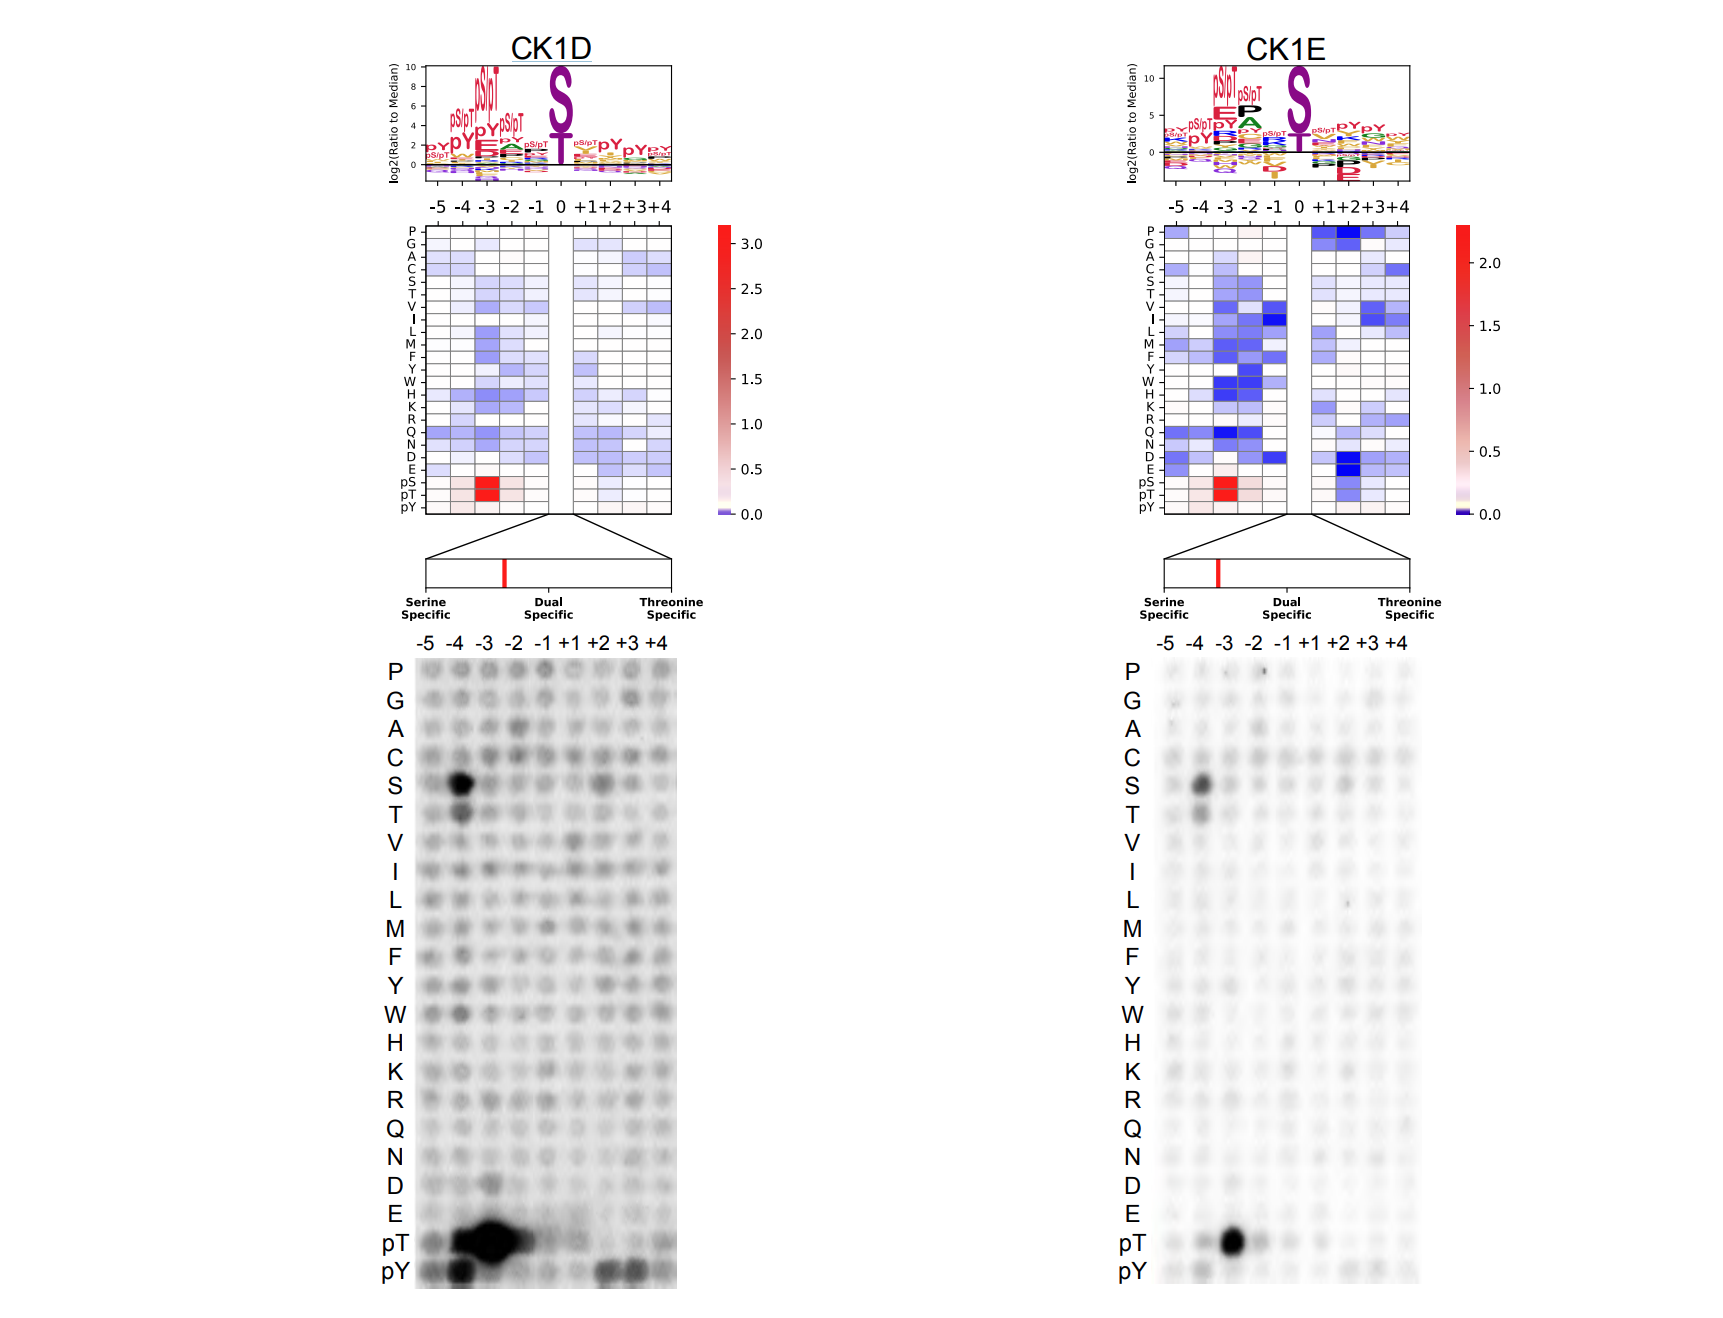

## Divide by median of each kinase

In [ ]:
rawT = raw.T

In [ ]:
r =rawT/rawT.median()

In [ ]:
median_raw = r.T

In [ ]:
median_raw

,-5P,-5G,-5A,-5C,-5S,-5T,-5V,-5I,-5L,-5M,-5F,-5Y,-5W,-5H,-5K,-5R,-5Q,-5N,-5D,-5E,-5s,-5t,-5y,-4P,-4G,-4A,-4C,-4S,-4T,-4V,-4I,-4L,-4M,-4F,-4Y,-4W,-4H,-4K,-4R,-4Q,-4N,-4D,-4E,-4s,-4t,-4y,-3P,-3G,-3A,-3C,-3S,-3T,-3V,-3I,-3L,-3M,-3F,-3Y,-3W,-3H,-3K,-3R,-3Q,-3N,-3D,-3E,-3s,-3t,-3y,-2P,-2G,-2A,-2C,-2S,-2T,-2V,-2I,-2L,-2M,-2F,-2Y,-2W,-2H,-2K,-2R,-2Q,-2N,-2D,-2E,-2s,-2t,-2y,-1P,-1G,-1A,-1C,-1S,-1T,-1V,-1I,-1L,-1M,-1F,-1Y,-1W,-1H,-1K,-1R,-1Q,-1N,-1D,-1E,-1s,-1t,-1y,1P,1G,1A,1C,1S,1T,1V,1I,1L,1M,1F,1Y,1W,1H,1K,1R,1Q,1N,1D,1E,1s,1t,1y,2P,2G,2A,2C,2S,2T,2V,2I,2L,2M,2F,2Y,2W,2H,2K,2R,2Q,2N,2D,2E,2s,2t,2y,3P,3G,3A,3C,3S,3T,3V,3I,3L,3M,3F,3Y,3W,3H,3K,3R,3Q,3N,3D,3E,3s,3t,3y,4P,4G,4A,4C,4S,4T,4V,4I,4L,4M,4F,4Y,4W,4H,4K,4R,4Q,4N,4D,4E,4s,4t,4y
kinase,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
AAK1,1.503282,0.511463,0.592559,0.927270,0.976171,1.641821,1.985494,3.244430,2.072995,1.803270,0.887077,1.986715,0.656950,0.691952,0.546355,1.995208,1.169529,0.574363,0.334680,0.319417,0.420270,0.420270,1.275614,1.038560,1.248929,1.373738,1.060104,1.128117,1.305467,1.203090,1.208351,1.442641,1.348404,1.010704,1.039137,0.784751,1.000000,1.573248,1.390136,1.219039,0.834812,0.645849,1.088238,0.645175,0.645175,0.659144,1.761357,0.831257,1.816871,1.036034,1.330991,1.344692,1.040764,0.972956,0.856378,1.269940,0.790921,0.667920,0.689750,0.645478,0.839711,0.943155,1.129122,0.945134,0.441039,0.601250,0.491542,0.491542,0.444935,0.437517,0.546135,1.040464,1.106906,1.128483,1.666804,0.657613,0.730435,1.100444,2.254437,0.649539,0.770922,0.559085,1.095427,1.135181,1.072421,2.932596,1.562049,1.555311,1.229785,0.404799,0.404799,0.939309,2.516001,1.564228,0.852928,0.676031,0.582651,0.697220,0.867846,0.962755,1.448722,1.226693,1.206404,1.720972,0.974383,1.524857,2.722895,2.045332,0.879904,0.960651,0.357601,0.323672,0.268114,0.268114,0.395334,1.266590,19.736375,0.852294,0.593696,0.542109,1.759152,0.292930,0.278843,0.357670,0.337856,0.352070,0.390823,0.443616,0.437830,0.530788,0.681305,0.377478,0.465633,0.280681,0.268428,0.336823,0.336823,0.274361,1.010691,1.437024,1.438166,1.278323,1.624704,6.184624,1.040708,0.709932,0.793577,0.922407,0.931775,0.880346,1.097806,1.188497,1.106387,1.484819,1.479314,1.599273,1.059157,1.004348,0.785062,0.785062,0.786723,1.554433,2.106004,1.327953,1.647996,1.673073,7.155650,1.391792,0.884591,1.114798,0.996880,0.980638,1.215086,1.096619,1.536942,1.685378,2.055577,1.421407,1.677414,0.923683,0.847584,0.764311,0.764311,0.818225,1.333589,1.490401,1.371260,1.247102,1.155423,2.366506,0.897287,0.882215,0.978946,0.985735,1.111606,1.106652,1.755030,1.188678,1.764673,1.971054,1.349155,1.256553,0.827056,0.971686,0.534067,0.534067,0.574388
ACVR2A,0.806757,0.934908,1.134036,1.352548,1.143134,1.228698,1.161923,1.214557,1.157333,1.012863,1.166681,1.122550,1.560719,1.108057,0.991710,0.923769,0.836389,1.041976,1.725809,1.534033,1.522256,1.522256,1.477926,0.838836,0.988593,0.999460,1.413838,1.393381,1.448072,0.979215,0.948183,0.936779,1.038585,1.114810,1.055236,1.358536,0.993196,0.731284,0.823610,0.868790,0.902858,1.873751,1.565598,1.456703,1.456703,1.227604,0.866811,1.126978,0.926227,1.445000,1.435760,1.485550,0.941899,0.867866,0.826480,0.888701,0.890090,0.949196,1.019450,0.913772,0.611938,0.794912,0.876592,0.866851,1.812474,2.079010,2.079497,2.079497,1.682542,0.385929,0.601185,0.637658,2.111854,1.534319,1.323954,0.603840,0.545489,0.517961,0.479248,0.606495,0.598257,0.648958,0.585977,0.426160,0.606536,0.924229,0.812668,5.171066,6.288601,1.215504,1.215504,0.866575,0.643308,0.542622,0.782609,2.399383,1.274495,1.342809,1.051431,0.765560,1.212965,1.370639,1.113151,1.267231,1.320608,1.018590,0.506471,0.549441,0.856362,0.776919,1.171245,1.231583,1.306376,1.306376,1.723991,0.317206,0.536191,0.603078,1.687763,1.116209,1.254159,1.234913,1.095558,0.813825,0.928033,0.868276,0.904786,0.896044,0.652448,0.304783,0.3

In [ ]:
dd = compare_k(median_raw, 'CK1D','CK1E')
dd.query('aa_x == "t"')

,substrate,CK1D,position_x,aa_x,CK1E,position_y,aa_y
21,-5t,1.650360,-5,t,1.723603,-5,t
44,-4t,5.699743,-4,t,4.499462,-4,t
67,-3t,57.866269,-3,t,44.406346,-3,t
90,-2t,5.039228,-2,t,4.681032,-2,t
113,-1t,1.606460,-1,t,1.728785,-1,t
136,1t,1.367768,1,t,1.356154,1,t
159,2t,0.890729,2,t,0.683243,2,t
182,3t,0.997794,3,t,0.869862,3,t
205,4t,1.310527,4,t,0.831911,4,t


The values look much similar after transformation

Let's check CDK4 and CDK6
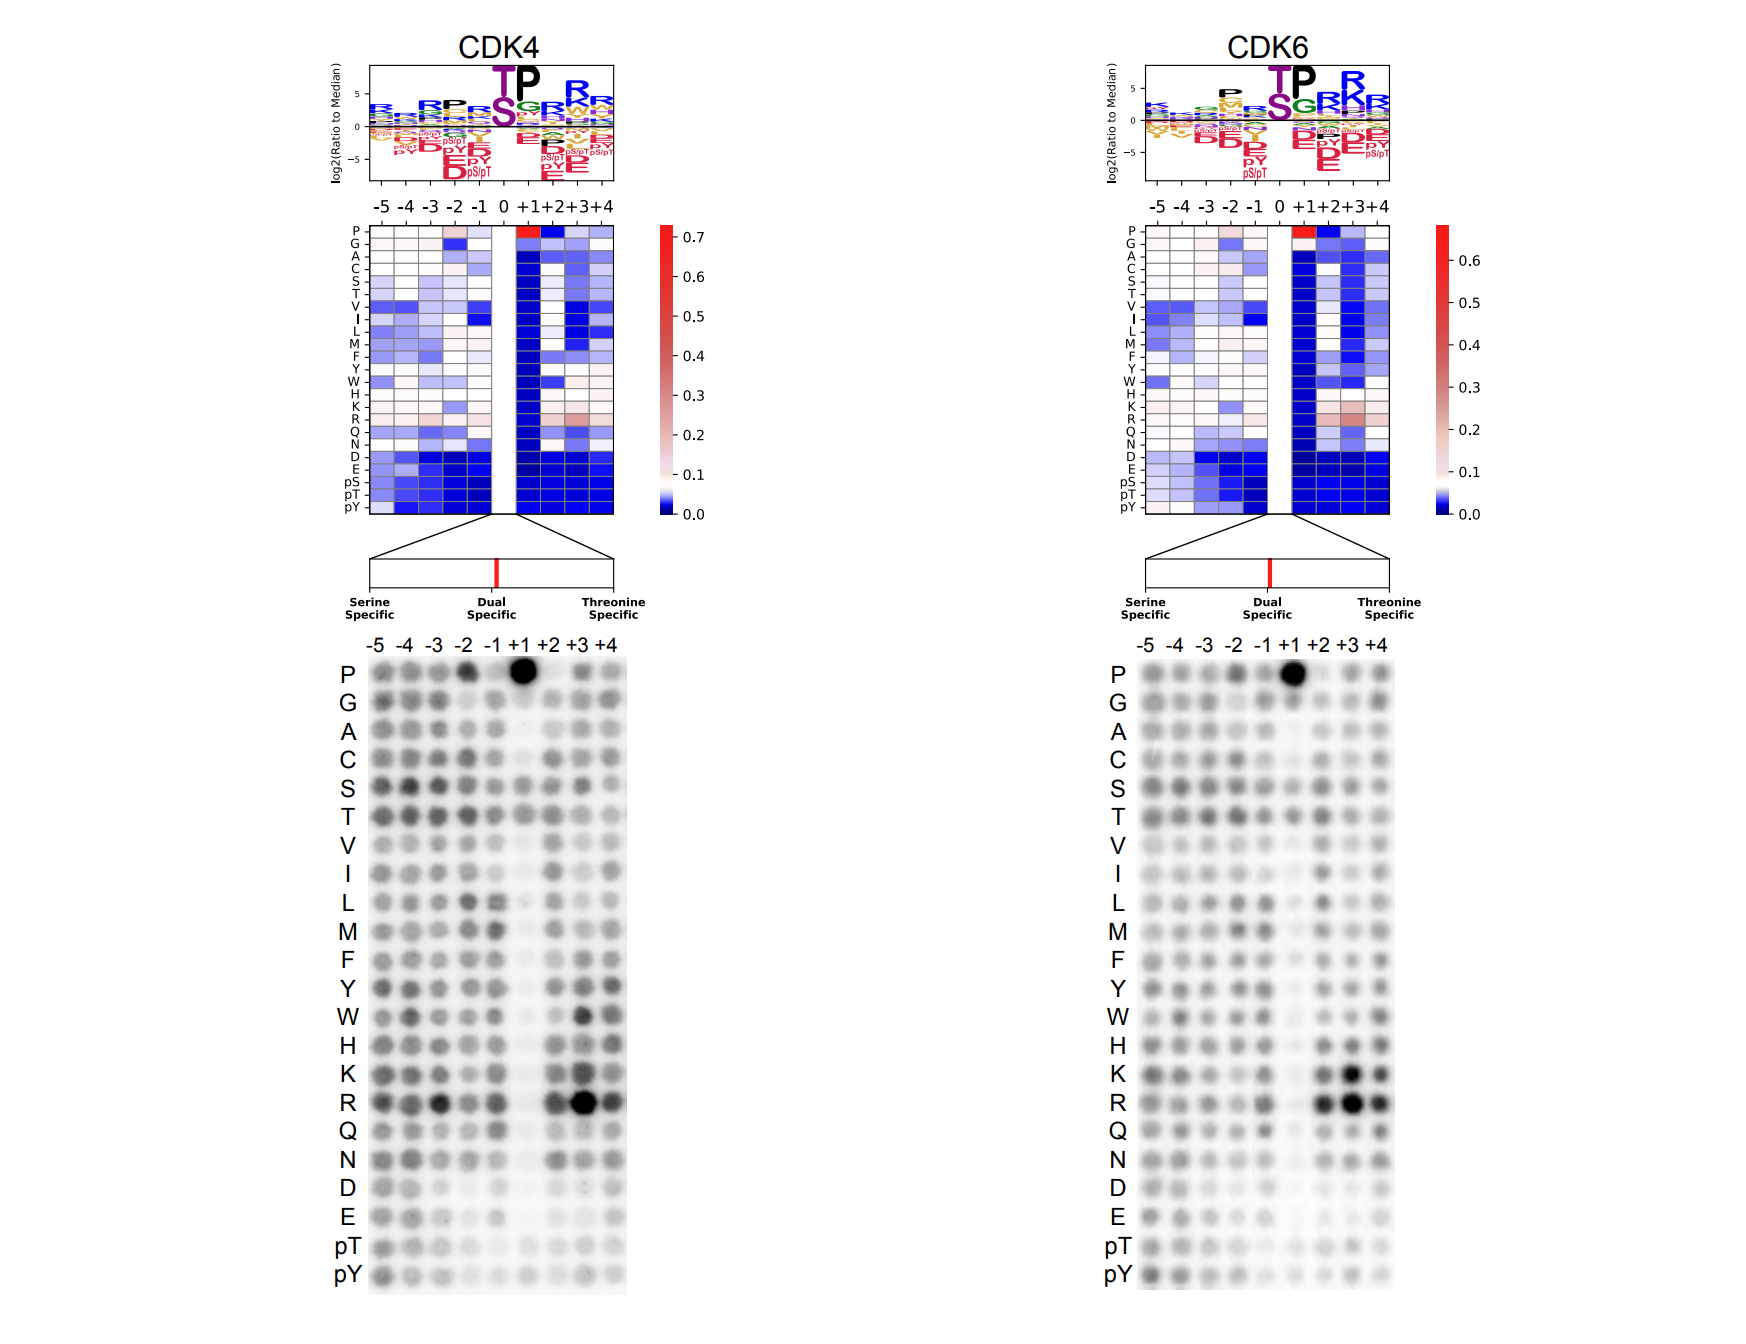

In [ ]:
dd = compare_k(median_raw, 'CDK4','CDK6')
dd.query('aa_x == "P"')

,substrate,CDK4,position_x,aa_x,CDK6,position_y,aa_y
0,-5P,1.486837,-5,P,1.534172,-5,P
23,-4P,1.445209,-4,P,1.241710,-4,P
46,-3P,1.279214,-3,P,1.172169,-3,P
69,-2P,2.581974,-2,P,2.115721,-2,P
92,-1P,0.984153,-1,P,1.364477,-1,P
115,1P,12.510293,1,P,11.594809,1,P
138,2P,0.467161,2,P,0.522157,2,P
161,3P,1.284164,3,P,1.168776,3,P
184,4P,0.971023,4,P,1.320096,4,P


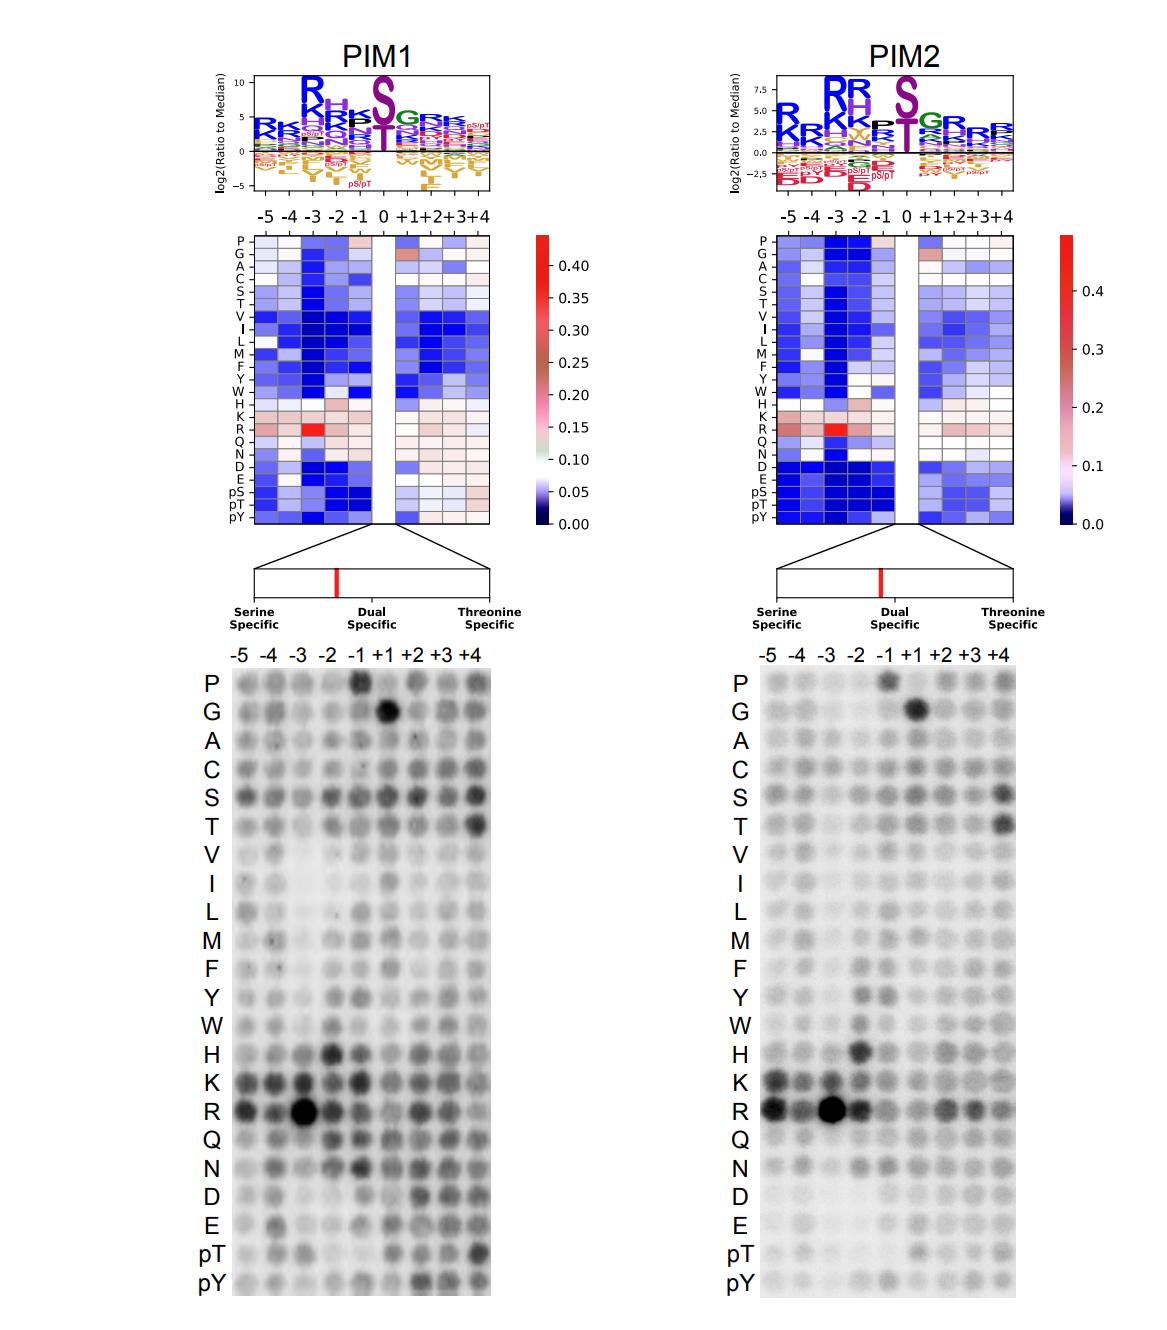

In [ ]:
dd = compare_k(median_raw, 'PIM1','PIM2')
dd.query('aa_x == "R"')

,substrate,PIM1,position_x,aa_x,PIM2,position_y,aa_y
15,-5R,2.715235,-5,R,5.014151,-5,R
38,-4R,2.084921,-4,R,3.011525,-4,R
61,-3R,10.230055,-3,R,12.661638,-3,R
84,-2R,2.711946,-2,R,4.079135,-2,R
107,-1R,1.927769,-1,R,1.845464,-1,R
130,1R,1.320423,1,R,1.572473,1,R
153,2R,2.311790,2,R,2.953564,2,R
176,3R,1.899686,3,R,2.678183,3,R
199,4R,1.132514,4,R,2.020649,4,R


Looks in a similar range

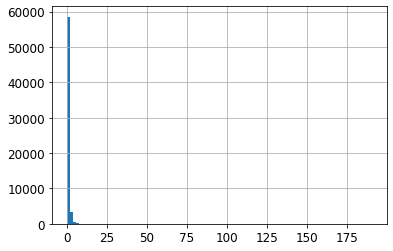

In [ ]:
median_raw.unstack().hist(bins=100);

In [ ]:
median_raw.max(1).sort_values()

kinase
BMPR2       2.047176
WNK3        2.090431
DLK         2.155399
MASTL       2.183965
ANKRD3      2.357225
             ...    
CK1G2      69.948590
YANK3      70.027588
GSK3B      71.999914
CK1A       98.693839
CK1G3     190.436832
Length: 303, dtype: float64

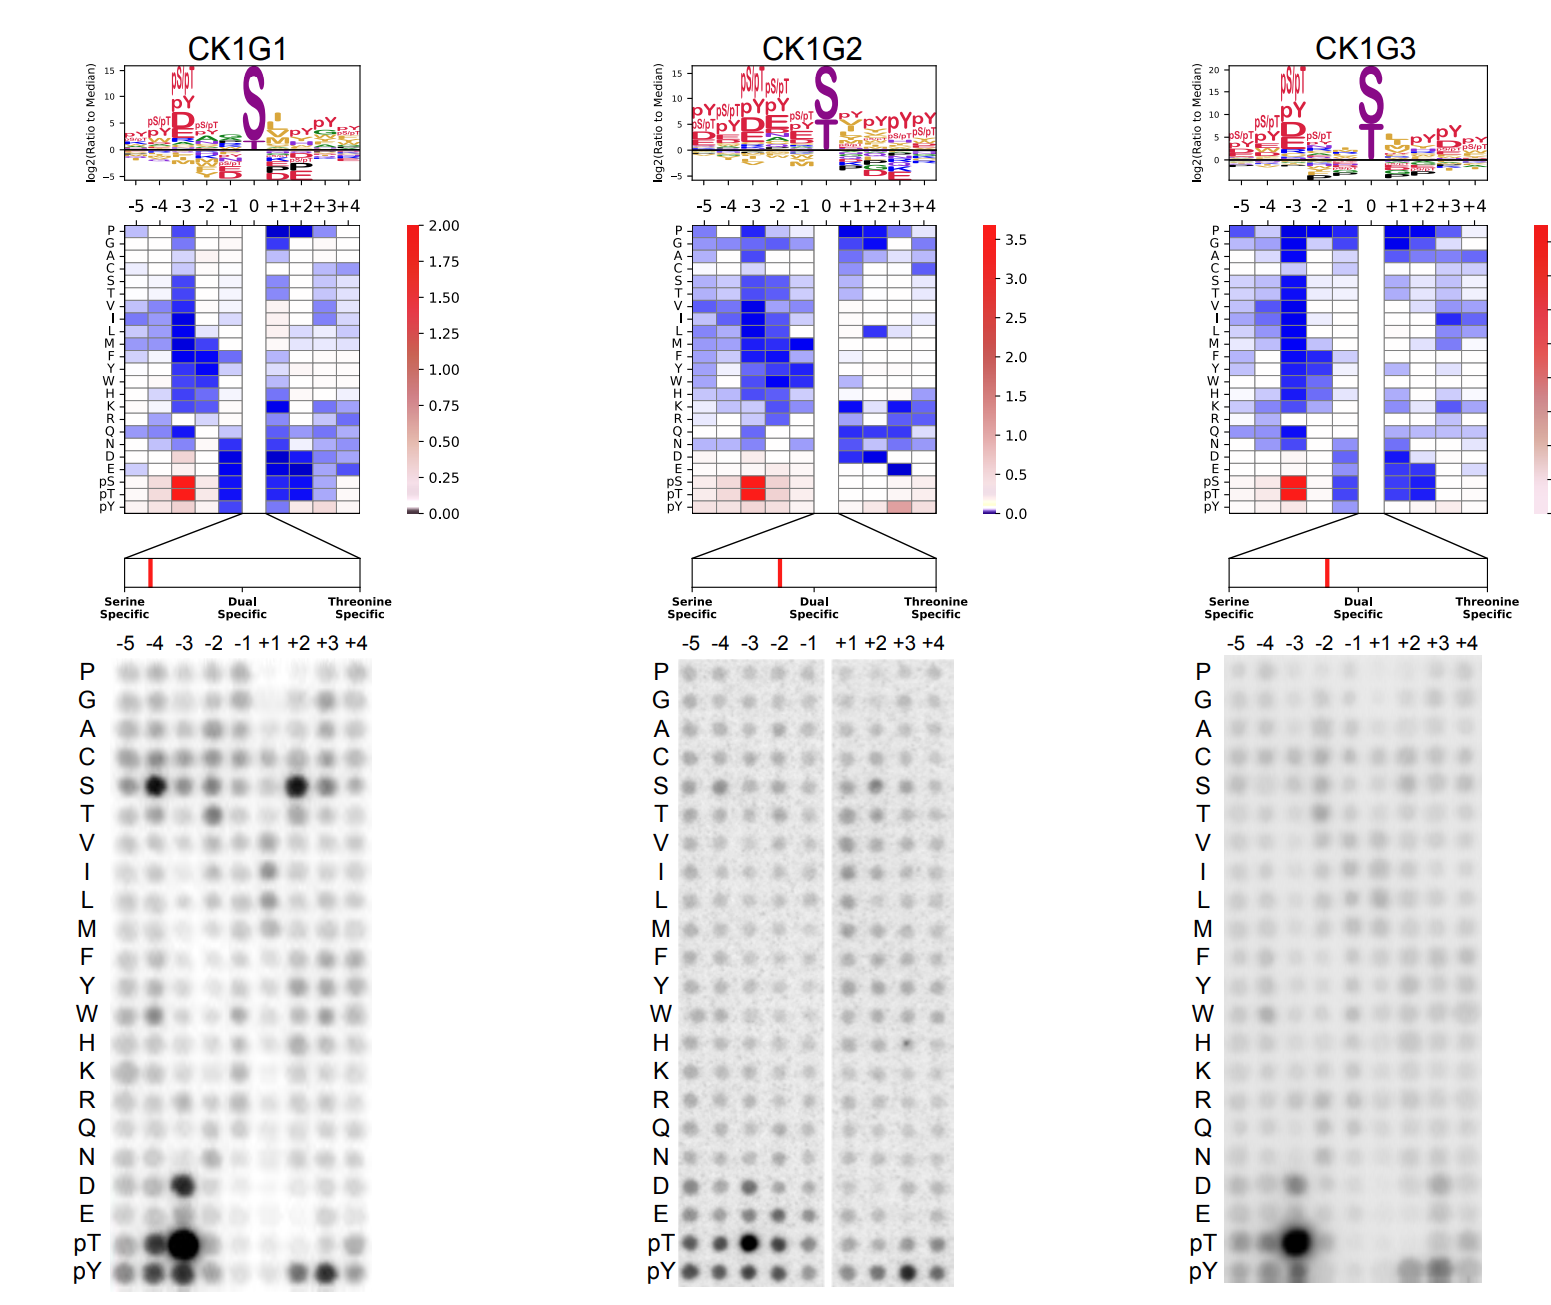

In [ ]:
dd = compare_k(median_raw, 'CK1G1','CK1G3')
dd.query('aa_x == "t"')

,substrate,CK1G1,position_x,aa_x,CK1G3,position_y,aa_y
21,-5t,1.835233,-5,t,4.840743,-5,t
44,-4t,5.359722,-4,t,12.387569,-4,t
67,-3t,40.139436,-3,t,190.436832,-3,t
90,-2t,2.831003,-2,t,4.672477,-2,t
113,-1t,0.531625,-1,t,0.672323,-1,t
136,1t,0.433406,1,t,0.558777,1,t
159,2t,0.488214,2,t,0.577204,2,t
182,3t,0.907070,3,t,1.732265,3,t
205,4t,1.681322,4,t,2.548106,4,t


In [ ]:
dd = compare_k(median_raw, 'CK1G1','CK1G2')
dd.query('aa_x == "t"')

,substrate,CK1G1,position_x,aa_x,CK1G2,position_y,aa_y
21,-5t,1.835233,-5,t,6.881756,-5,t
44,-4t,5.359722,-4,t,7.907495,-4,t
67,-3t,40.139436,-3,t,69.948590,-3,t
90,-2t,2.831003,-2,t,10.038186,-2,t
113,-1t,0.531625,-1,t,3.115048,-1,t
136,1t,0.433406,1,t,1.671759,1,t
159,2t,0.488214,2,t,1.203963,2,t
182,3t,0.907070,3,t,2.218114,3,t
205,4t,1.681322,4,t,3.099403,4,t


From the values, CK1G2> CK1G1, but from the figures CK1G2 looks weaker than CK1G1, which can be reflected from the raw data

In [ ]:
dd = compare_k(raw, 'CK1G1','CK1G2')
dd.query('aa_x == "t"')

,substrate,CK1G1,position_x,aa_x,CK1G2,position_y,aa_y
21,-5t,2.198092e+07,-5,t,18682.783,-5,t
44,-4t,6.419438e+07,-4,t,21467.490,-4,t
67,-3t,4.807574e+08,-3,t,189898.392,-3,t
90,-2t,3.390745e+07,-2,t,27251.949,-2,t
113,-1t,6.367370e+06,-1,t,8456.820,-1,t
136,1t,5.190983e+06,1,t,4538.538,1,t
159,2t,5.847430e+06,2,t,3268.552,2,t
182,3t,1.086415e+07,3,t,6021.799,3,t
205,4t,2.013750e+07,4,t,8414.347,4,t


## Standardize

Apply (x - mean) / std to each kinase

In [ ]:
raw.head(2)

,-5P,-5G,-5A,-5C,-5S,-5T,-5V,-5I,-5L,-5M,-5F,-5Y,-5W,-5H,-5K,-5R,-5Q,-5N,-5D,-5E,-5s,-5t,-5y,-4P,-4G,-4A,-4C,-4S,-4T,-4V,-4I,-4L,-4M,-4F,-4Y,-4W,-4H,-4K,-4R,-4Q,-4N,-4D,-4E,-4s,-4t,-4y,-3P,-3G,-3A,-3C,-3S,-3T,-3V,-3I,-3L,-3M,-3F,-3Y,-3W,-3H,-3K,-3R,-3Q,-3N,-3D,-3E,-3s,-3t,-3y,-2P,-2G,-2A,-2C,-2S,-2T,-2V,-2I,-2L,-2M,-2F,-2Y,-2W,-2H,-2K,-2R,-2Q,-2N,-2D,-2E,-2s,-2t,-2y,-1P,-1G,-1A,-1C,-1S,-1T,-1V,-1I,-1L,-1M,-1F,-1Y,-1W,-1H,-1K,-1R,-1Q,-1N,-1D,-1E,-1s,-1t,-1y,1P,1G,1A,1C,1S,1T,1V,1I,1L,1M,1F,1Y,1W,1H,1K,1R,1Q,1N,1D,1E,1s,1t,1y,2P,2G,2A,2C,2S,2T,2V,2I,2L,2M,2F,2Y,2W,2H,2K,2R,2Q,2N,2D,2E,2s,2t,2y,3P,3G,3A,3C,3S,3T,3V,3I,3L,3M,3F,3Y,3W,3H,3K,3R,3Q,3N,3D,3E,3s,3t,3y,4P,4G,4A,4C,4S,4T,4V,4I,4L,4M,4F,4Y,4W,4H,4K,4R,4Q,4N,4D,4E,4s,4t,4y
kinase,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
AAK1,7614134.38,2590563.43,3001315.49,4696631.43,4944311.77,8315837.72,10056545.00,16433061.43,10499735.53,9133577.86,4493053.86,10062728.22,3327454.51,3504742.95,2767294.24,10105742.33,5923673.04,2909152.87,1695155.97,1617848.59,2128670.48,2128670.48,6460994.89,5260312.92,6325834.43,6957993.77,5369434.90,5713920.54,6612201.68,6093662.03,6120308.98,7306988.18,6829677.84,5119221.55,5263235.93,3974771.07,5065007.89,7968511.43,7041049.08,6174443.51,4228327.20,3271230.67,5511933.84,3267817.62,3267817.62,3338569.94,8921287.46,4210322.63,9202467.84,5247517.95,6741480.38,6810877.54,5271476.43,4928031.78,4337561.80,6432256.95,4006022.34,3383022.36,3493591.45,3269349.53,4253143.83,4777087.04,5719013.51,4787112.42,2233864.71,3045337.18,2489664.19,2489664.19,2253600.17,2216028.59,2766177.13,5269960.36,5606488.15,5715776.94,8442376.88,3330815.96,3699660.08,5573758.37,11418739.19,3289921.82,3904724.03,2831767.59,5548344.99,5749698.72,5431820.79,14853623.17,7911791.51,7877660.92,6228872.38,2050311.16,2050311.16,4757608.56,12743566.74,7922825.91,4320088.81,3424101.65,2951131.47,3531424.24,4395648.71,4876361.62,7337788.35,6213208.09,6110446.84,8716736.64,4935259.96,7723412.28,13791485.68,10359621.72,4456718.79,4865705.32,1811253.16,1639403.12,1357999.07,1357999.07,2002371.19,6415286.88,99964895.25,4316874.96,3007074.62,2745785.51,8910120.32,1483692.44,1412340.64,1811600.47,1711244.81,1783236.05,1979521.48,2246919.31,2217612.04,2688447.64,3450817.64,1911929.56,2358432.64,1421652.45,1359587.84,1706013.09,1706013.09,1389641.63,5119157.71,7278540.04,7284322.40,6474714.78,8229140.75,31325167.00,5271194.4,3595811.04,4019474.24,4672000.36,4719445.91,4458958.54,5560394.09,6019747.75,5603858.75,7520620.82,7492737.30,8100331.77,5364638.21,5087031.12,3976345.18,3976345.18,3984759.21,7873214.56,10666925.10,6726092.35,8347110.75,8474126.59,36243425.13,7049439.08,4480458.41,5646461.38,5049205.04,4966940.21,6154422.64,5554384.65,7784625.71,8536454.84,10411516.21,7199439.88,8496115.61,4678462.79,4293019.55,3871242.35,3871242.35,4144314.24,6754640.94,7548893.13,6945441.59,6316583.85,5852227.64,11986373.78,4544765.44,4468425.80,4958371.35,4992757.20,5630292.14,5605199.37,8889242.83,6020662.73,8938081.41,9983402.01,6833481.55,6364453.29,4189045.89,4921595.57,2705053.53,2705053.53,2909279.71
ACVR2A,4991039.28,5783855.86,7015770.78,8367603.09,7072052.48,7601399.57,7188292.41,7513915.73,7159894.71,6266122.81,7217726.01,6944709.95,9655463.75,6855044.90,6135259.88,5714942.29,5174360.28,6446237.55,10676798.47,9490370.51,9417512.45,9417512.45,9143262.67,5189500.90,6115977.27,6183207.45,8746774.91,8620216.35,8958568.82,6057960.27,5865979.65,5795429.17,6425254.28,6896823.79,6528270.38,8404648.40,6144455.59,4524121.26,5095303.46,5374811.94,5585576.72,11592053.32,9685649.12,9011965.48,9011965.48,7594632.10,5362570.64,6972103.63,5730145.40,8939563.00,8882396.89,9190426.82,5827104.19,5369092.23,5113057.94,5497993.14,5506587.16,5872246.52,6306875.17,5653091.40,3785783.33,4917762.58,5423081.45,5362812.26,11212957.52,12861894.95,12864905.98,128

In [ ]:
scaler = StandardScaler()

X = scaler.fit_transform(raw.T).T

scaled = raw.copy()
scaled.loc[:,:] = X

In [ ]:
scaled.head(2)

,-5P,-5G,-5A,-5C,-5S,-5T,-5V,-5I,-5L,-5M,-5F,-5Y,-5W,-5H,-5K,-5R,-5Q,-5N,-5D,-5E,-5s,-5t,-5y,-4P,-4G,-4A,-4C,-4S,-4T,-4V,-4I,-4L,-4M,-4F,-4Y,-4W,-4H,-4K,-4R,-4Q,-4N,-4D,-4E,-4s,-4t,-4y,-3P,-3G,-3A,-3C,-3S,-3T,-3V,-3I,-3L,-3M,-3F,-3Y,-3W,-3H,-3K,-3R,-3Q,-3N,-3D,-3E,-3s,-3t,-3y,-2P,-2G,-2A,-2C,-2S,-2T,-2V,-2I,-2L,-2M,-2F,-2Y,-2W,-2H,-2K,-2R,-2Q,-2N,-2D,-2E,-2s,-2t,-2y,-1P,-1G,-1A,-1C,-1S,-1T,-1V,-1I,-1L,-1M,-1F,-1Y,-1W,-1H,-1K,-1R,-1Q,-1N,-1D,-1E,-1s,-1t,-1y,1P,1G,1A,1C,1S,1T,1V,1I,1L,1M,1F,1Y,1W,1H,1K,1R,1Q,1N,1D,1E,1s,1t,1y,2P,2G,2A,2C,2S,2T,2V,2I,2L,2M,2F,2Y,2W,2H,2K,2R,2Q,2N,2D,2E,2s,2t,2y,3P,3G,3A,3C,3S,3T,3V,3I,3L,3M,3F,3Y,3W,3H,3K,3R,3Q,3N,3D,3E,3s,3t,3y,4P,4G,4A,4C,4S,4T,4V,4I,4L,4M,4F,4Y,4W,4H,4K,4R,4Q,4N,4D,4E,4s,4t,4y
kinase,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
AAK1,0.203681,-0.457705,-0.403626,-0.180427,-0.147818,0.296065,0.525241,1.364751,0.583590,0.403726,-0.207229,0.526055,-0.360688,-0.337347,-0.434437,0.531718,-0.018879,-0.41576,-0.575591,-0.585769,-0.518516,-0.518516,0.051863,-0.106215,0.034068,0.117296,-0.091848,-0.046494,0.071770,0.003501,0.007009,0.163244,0.100403,-0.124790,-0.105830,-0.275465,-0.131928,0.250337,0.128231,0.014137,-0.242082,-0.368090,-0.073087,-0.368540,-0.368540,-0.359225,0.375777,-0.244453,0.412796,-0.107899,0.088791,0.097927,-0.104745,-0.149962,-0.227701,0.048079,-0.271350,-0.353372,-0.338815,-0.368338,-0.238815,-0.169834,-0.045824,-0.168515,-0.504666,-0.397831,-0.470989,-0.470989,-0.502068,-0.507014,-0.434584,-0.104944,-0.060638,-0.046250,0.312725,-0.360245,-0.311685,-0.064947,0.704582,-0.365629,-0.284687,-0.425948,-0.068293,-0.041784,-0.083634,1.156807,0.242870,0.238376,0.021303,-0.528832,-0.528832,-0.172399,0.879005,0.244323,-0.230001,-0.347964,-0.410233,-0.333834,-0.220053,-0.156764,0.167299,0.019240,0.005711,0.348846,-0.149010,0.218068,1.016970,0.565143,-0.212013,-0.158167,-0.560306,-0.582931,-0.619980,-0.619980,-0.535144,0.045845,12.362261,-0.230424,-0.402868,-0.437269,0.374306,-0.603431,-0.612825,-0.560260,-0.573473,-0.563994,-0.538152,-0.502948,-0.506806,-0.444817,-0.344446,-0.547051,-0.488266,-0.611599,-0.619770,-0.574161,-0.574161,-0.615814,-0.124799,0.159498,0.160259,0.053669,0.284651,3.325393,-0.104782,-0.325357,-0.269579,-0.183670,-0.177423,-0.211718,-0.066707,-0.006230,-0.060985,0.191370,0.187699,0.267692,-0.092480,-0.129028,-0.275257,-0.275257,-0.274150,0.237791,0.605601,0.086765,0.300182,0.316905,3.972914,0.129336,-0.208888,-0.055376,-0.134008,-0.144839,0.011501,-0.067498,0.226128,0.325111,0.571975,0.149084,0.319800,-0.182819,-0.233565,-0.289095,-0.289095,-0.253143,0.090523,0.195092,0.115644,0.03285,-0.028285,0.779315,-0.200421,-0.210472,-0.145967,-0.141440,-0.057504,-0.060808,0.371558,-0.006110,0.377988,0.515611,0.100903,0.039153,-0.247254,-0.150809,-0.442631,-0.442631,-0.415743
ACVR2A,-0.497906,-0.307642,-0.012000,0.312420,0.001507,0.128542,0.029403,0.107547,0.022588,-0.191905,0.036466,-0.029054,0.621488,-0.050572,-0.223310,-0.324180,-0.453912,-0.14868,0.866593,0.581868,0.564383,0.564383,0.498567,-0.450278,-0.227937,-0.211803,0.403416,0.373043,0.454243,-0.241861,-0.287933,-0.304864,-0.153715,-0.040546,-0.128993,0.321310,-0.221103,-0.609960,-0.472884,-0.405806,-0.355226,1.086241,0.628732,0.467057,0.467057,0.126918,-0.408744,-0.022480,-0.320531,0.449682,0.435963,0.509886,-0.297263,-0.407179,-0.468623,-0.376245,-0.374182,-0.286429,-0.182125,-0.339023,-0.787150,-0.515491,-0.394222,-0.408686,0.995263,1.390984,1.391707,1.391707,0.802355,-1.122702,-0.803114,-0.748963,1.439747,0.582292,0.269968,-0.799173,-0.885805,-0.926676,-0.984152,-0.795231,-0.807462,-0.732187,-0.825693,-1.062971,-0.795169,-0.323497,-0.489129,5.981701,7.640885,0.108953,0.108953,-0.409095,-0.740575,-0.890062,-0.533758,1.866636,0.196536,0.297961,-0.134642,-0.559071,0.105184,0.339279,-0.043009,0.185751,0.264999,-0.183401,-0.943735,-0.879938,-0.424

In [ ]:
dd = compare_k(scaled, 'CK1D','CK1E')
dd.query('aa_x == "t"')

,substrate,CK1D,position_x,aa_x,CK1E,position_y,aa_y
21,-5t,-0.013819,-5,t,0.013220,-5,t
44,-4t,0.709939,-4,t,0.650988,-4,t
67,-3t,10.033810,-3,t,9.819809,-3,t
90,-2t,0.591883,-2,t,0.692705,-2,t
113,-1t,-0.021665,-1,t,0.014411,-1,t
136,1t,-0.064327,1,t,-0.071203,1,t
159,2t,-0.149590,2,t,-0.225808,2,t
182,3t,-0.130454,3,t,-0.182932,3,t
205,4t,-0.074558,4,t,-0.191651,4,t


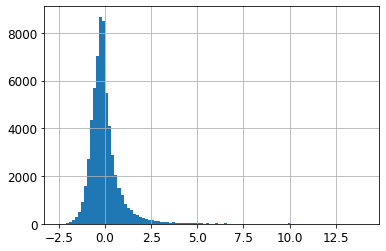

In [ ]:
scaled.unstack().hist(bins=100);

In [ ]:
# To save scaler for test
dump(scaler, 'standard_scaler.joblib')

# To reload
# scaler = load('standard_scaler.joblib')

In [ ]:
dd = compare_k(scaled, 'CK1G1','CK1G3')
dd.query('aa_x == "t"')

,substrate,CK1G1,position_x,aa_x,CK1G3,position_y,aa_y
21,-5t,0.043769,-5,t,0.081652,-5,t
44,-4t,0.938098,-4,t,0.487890,-4,t
67,-3t,9.763351,-3,t,10.072095,-3,t
90,-2t,0.296443,-2,t,0.072594,-2,t
113,-1t,-0.287018,-1,t,-0.142730,-1,t
136,1t,-0.311941,1,t,-0.148842,1,t
159,2t,-0.298033,2,t,-0.147850,2,t
182,3t,-0.191750,3,t,-0.085674,3,t
205,4t,0.004714,4,t,-0.041758,4,t


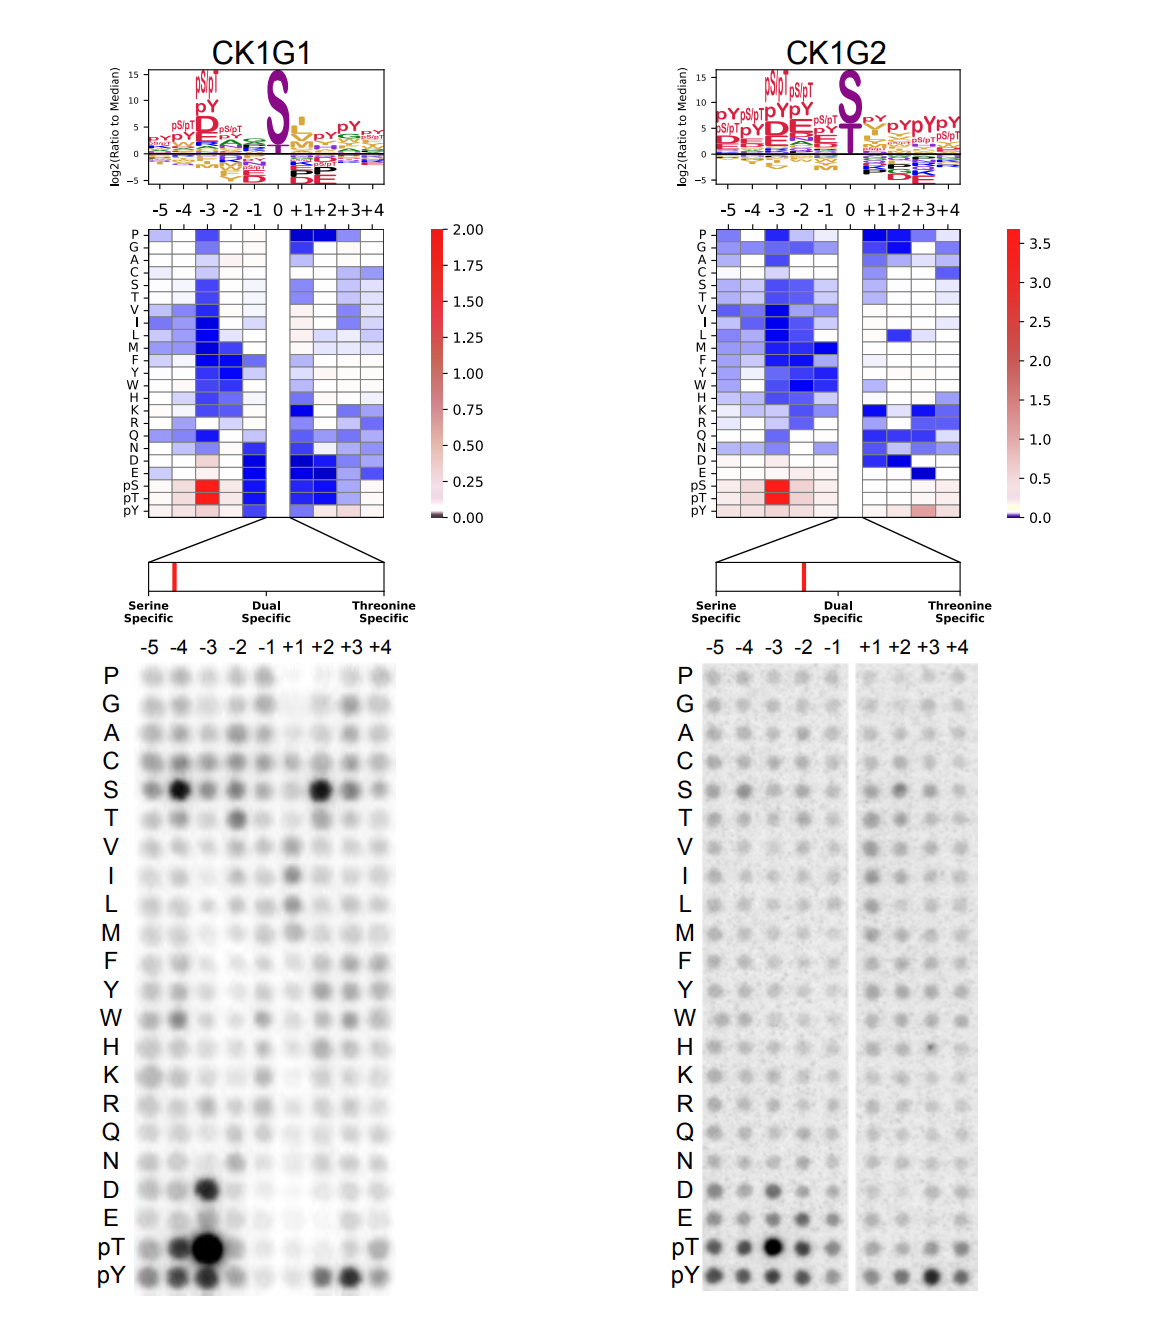

In [ ]:
dd = compare_k(scaled, 'CK1G1','CK1G2')
dd.query('aa_x == "t"')

,substrate,CK1G1,position_x,aa_x,CK1G2,position_y,aa_y
21,-5t,0.043769,-5,t,0.661335,-5,t
44,-4t,0.938098,-4,t,0.808228,-4,t
67,-3t,9.763351,-3,t,9.692925,-3,t
90,-2t,0.296443,-2,t,1.113357,-2,t
113,-1t,-0.287018,-1,t,0.121918,-1,t
136,1t,-0.311941,1,t,-0.084771,1,t
159,2t,-0.298033,2,t,-0.151762,2,t
182,3t,-0.191750,3,t,-0.006529,3,t
205,4t,0.004714,4,t,0.119677,4,t


The disadvantage of standard scaler is that it makes weak signal in CK1G2 as strong as CK1G1

## Log transformation

In [ ]:
log = np.log(raw + 1)

In [ ]:
dd = compare_k(log, 'CK1G1','CK1G2')
dd.query('aa_x == "t"')

,substrate,CK1G1,position_x,aa_x,CK1G2,position_y,aa_y
21,-5t,16.905685,-5,t,9.835411,-5,t
44,-4t,17.977426,-4,t,9.974342,-4,t
67,-3t,19.990873,-3,t,12.154250,-3,t
90,-2t,17.339145,-2,t,10.212917,-2,t
113,-1t,15.666697,-1,t,9.042847,-1,t
136,1t,15.462434,1,t,8.420581,1,t
159,2t,15.581513,2,t,8.092408,2,t
182,3t,16.200979,3,t,8.703307,3,t
205,4t,16.818094,4,t,9.037812,4,t


It diminishes the differences between background noise and true signal, so it's not good

## Percentile Rank

A percentile rank of a score is the percentage of scores in its frequency distribution that are equal to or lower than it. The percentile rank can be a very useful tool when you want to know the relative position of a particular value within the distribution. The advantage of using percentile rank is that it provides a clear and interpretable understanding of the position of a score relative to others. However, one limitation is that it doesn't take into account the magnitude of scores - two very different scores could have the same percentile rank if they're higher than the same proportion of scores in the dataset.

Percentile Rank = (Number of Values Below the Given Value) / (Total Number of Values) * 100

In [ ]:
rank = raw.rank(axis=1, pct=True)

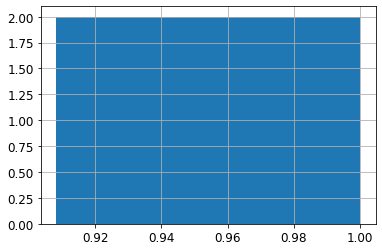

In [ ]:
rank.loc['AKT1'].sort_values(ascending=False)[:20].hist();

In [ ]:
dd = compare_k(rank, 'CK1G1','CK1G2')
dd.query('aa_x == "t"')

,substrate,CK1G1,position_x,aa_x,CK1G2,position_y,aa_y
21,-5t,0.871981,-5,t,0.949275,-5,t
44,-4t,0.968599,-4,t,0.963768,-4,t
67,-3t,0.997585,-3,t,0.997585,-3,t
90,-2t,0.944444,-2,t,0.983092,-2,t
113,-1t,0.103865,-1,t,0.900966,-1,t
136,1t,0.041063,1,t,0.799517,1,t
159,2t,0.079710,2,t,0.669082,2,t
182,3t,0.359903,3,t,0.847826,3,t
205,4t,0.823671,4,t,0.891304,4,t


After percentile ranking, values of each kinase are equally distributed, which eliminates their differences. Therefore, we will not choose this method.

## Post Process (unstack)

The following function will do several things:
- Unstack the dataframe for training purpose
- Add position and aa info
- Remove values of 's' of each kinase as it is a duplicate of 't'

In [ ]:
raw_unstack = post_process(raw)

In [ ]:
median_unstack = post_process(median_raw)

In [ ]:
median_unstack.to_csv('median_unstack.csv', index=False)

In [ ]:
mean_unstack.head(2)

,kinase,substrate,target,position,aa
0,AAK1,-5P,1.254994,-5,P
1,ACVR2A,-5P,0.706368,-5,P


In [ ]:
median_unstack

,kinase,substrate,target,position,aa
0,AAK1,-5P,1.503282,-5,P
1,ACVR2A,-5P,0.806757,-5,P
2,ACVR2B,-5P,0.949373,-5,P
3,AKT1,-5P,1.033605,-5,P
4,AKT2,-5P,1.174954,-5,P
...,...,...,...,...,...
59989,YANK2,4y,11.625226,4,y
59990,YANK3,4y,10.048118,4,y
59991,YSK1,4y,0.414345,4,y
59992,YSK4,4y,0.760963,4,y


In [ ]:
mean_unstack.to_csv('mean_unstack.csv', index=False)

In [ ]:
mean_unstack

,kinase,substrate,target,position,aa
0,AAK1,-5P,1.254994,-5,P
1,ACVR2A,-5P,0.706368,-5,P
2,ACVR2B,-5P,0.842427,-5,P
3,AKT1,-5P,0.862181,-5,P
4,AKT2,-5P,0.939973,-5,P
...,...,...,...,...,...
59989,YANK2,4y,7.133034,4,y
59990,YANK3,4y,6.497018,4,y
59991,YSK1,4y,0.377163,4,y
59992,YSK4,4y,0.725139,4,y


In [ ]:
raw_unstack.to_csv('raw_unstack.csv',index=False)

In [ ]:
scaled2 = post_process(scaled)

In [ ]:
scaled2.head()

,kinase,substrate,target,position,aa
0,AAK1,-5P,0.752309,-5,P
1,ACVR2A,-5P,-0.604971,-5,P
2,ACVR2B,-5P,-0.176978,-5,P
3,AKT1,-5P,0.094880,-5,P
4,AKT2,-5P,0.227930,-5,P


In [ ]:
log2 = post_process(log)

In [ ]:
log2.head()

,kinase,substrate,target,position,aa
0,AAK1,-5P,15.845517,-5,P
1,ACVR2A,-5P,15.423155,-5,P
2,ACVR2B,-5P,17.091913,-5,P
3,AKT1,-5P,16.727835,-5,P
4,AKT2,-5P,15.509150,-5,P


In [ ]:
# Uncheck to save to csv
# log2.to_csv('log_raw.csv',index=False)
# scaled2.to_csv('scaled_log.csv',index=False)

## Download Directly

You can also download using Data

In [ ]:
s = Data.get_standard_unstack()

In [ ]:
s.head()

,kinase,substrate,target,position,aa
0,AAK1,-5P,0.203681,-5,P
1,ACVR2A,-5P,-0.497906,-5,P
2,ACVR2B,-5P,-0.274530,-5,P
3,AKT1,-5P,-0.138624,-5,P
4,AKT2,-5P,-0.052269,-5,P


In [ ]:
log = Data.get_log_unstack()

In [ ]:
log.head()

,kinase,substrate,target,position,aa
0,AAK1,-5P,15.845517,-5,P
1,ACVR2A,-5P,15.423155,-5,P
2,ACVR2B,-5P,17.091913,-5,P
3,AKT1,-5P,16.727835,-5,P
4,AKT2,-5P,15.509150,-5,P


## Stack back and convert back

If needed, we can also unstandardize back the data, and make a pivot table just like the raw data format

### Stack (pivot)

In [ ]:
s2 = s.pivot_table(values='target', index='kinase', columns='substrate')
l2 = log.pivot_table(values='target', index='kinase', columns='substrate')

In [ ]:
s2.head(2)

substrate,-1A,-1C,-1D,-1E,-1F,-1G,-1H,-1I,-1K,-1L,-1M,-1N,-1P,-1Q,-1R,-1S,-1T,-1V,-1W,-1Y,-1t,-1y,-2A,-2C,-2D,-2E,-2F,-2G,-2H,-2I,-2K,-2L,-2M,-2N,-2P,-2Q,-2R,-2S,-2T,-2V,-2W,-2Y,-2t,-2y,-3A,-3C,-3D,-3E,-3F,-3G,-3H,-3I,-3K,-3L,-3M,-3N,-3P,-3Q,-3R,-3S,-3T,-3V,-3W,-3Y,-3t,-3y,-4A,-4C,-4D,-4E,-4F,-4G,-4H,-4I,-4K,-4L,-4M,-4N,-4P,-4Q,-4R,-4S,-4T,-4V,-4W,-4Y,-4t,-4y,-5A,-5C,-5D,-5E,-5F,-5G,-5H,-5I,-5K,-5L,-5M,-5N,-5P,-5Q,-5R,-5S,-5T,-5V,-5W,-5Y,-5t,-5y,1A,1C,1D,1E,1F,1G,1H,1I,1K,1L,1M,1N,1P,1Q,1R,1S,1T,1V,1W,1Y,1t,1y,2A,2C,2D,2E,2F,2G,2H,2I,2K,2L,2M,2N,2P,2Q,2R,2S,2T,2V,2W,2Y,2t,2y,3A,3C,3D,3E,3F,3G,3H,3I,3K,3L,3M,3N,3P,3Q,3R,3S,3T,3V,3W,3Y,3t,3y,4A,4C,4D,4E,4F,4G,4H,4I,4K,4L,4M,4N,4P,4Q,4R,4S,4T,4V,4W,4Y,4t,4y
kinase,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
AAK1,-0.230001,-0.347964,-0.560306,-0.582931,0.005711,0.244323,0.218068,-0.156764,1.016970,0.167299,0.019240,-0.158167,0.879005,-0.212013,0.565143,-0.410233,-0.333834,-0.220053,-0.149010,0.348846,-0.619980,-0.535144,-0.104944,-0.060638,0.238376,0.021303,-0.365629,-0.434584,-0.068293,-0.311685,-0.041784,-0.064947,0.704582,0.242870,-0.507014,1.156807,-0.083634,-0.046250,0.312725,-0.360245,-0.425948,-0.284687,-0.528832,-0.172399,0.412796,-0.107899,-0.504666,-0.397831,-0.271350,-0.244453,-0.368338,-0.149962,-0.238815,-0.227701,0.048079,-0.168515,0.375777,-0.045824,-0.169834,0.088791,0.097927,-0.104745,-0.338815,-0.353372,-0.470989,-0.502068,0.117296,-0.091848,-0.368090,-0.073087,-0.124790,0.034068,-0.131928,0.007009,0.250337,0.163244,0.100403,-0.242082,-0.106215,0.014137,0.128231,-0.046494,0.071770,0.003501,-0.275465,-0.105830,-0.368540,-0.359225,-0.403626,-0.180427,-0.575591,-0.585769,-0.207229,-0.457705,-0.337347,1.364751,-0.434437,0.583590,0.403726,-0.41576,0.203681,-0.018879,0.531718,-0.147818,0.296065,0.525241,-0.360688,0.526055,-0.518516,0.051863,-0.230424,-0.402868,-0.611599,-0.619770,-0.563994,12.362261,-0.506806,-0.612825,-0.444817,-0.560260,-0.573473,-0.488266,0.045845,-0.547051,-0.344446,-0.437269,0.374306,-0.603431,-0.502948,-0.538152,-0.574161,-0.615814,0.160259,0.053669,-0.092480,-0.129028,-0.177423,0.159498,-0.006230,-0.325357,-0.060985,-0.269579,-0.183670,0.267692,-0.124799,0.187699,0.191370,0.284651,3.325393,-0.104782,-0.066707,-0.211718,-0.275257,-0.274150,0.086765,0.300182,-0.182819,-0.233565,-0.144839,0.605601,0.226128,-0.208888,0.325111,-0.055376,-0.134008,0.319800,0.237791,0.149084,0.571975,0.316905,3.972914,0.129336,-0.067498,0.011501,-0.289095,-0.253143,0.115644,0.03285,-0.247254,-0.150809,-0.057504,0.195092,-0.006110,-0.210472,0.377988,-0.145967,-0.141440,0.039153,0.090523,0.100903,0.515611,-0.028285,0.779315,-0.200421,0.371558,-0.060808,-0.442631,-0.415743
ACVR2A,-0.533758,1.866636,0.043243,0.132826,-0.043009,-0.890062,-0.183401,-0.559071,-0.943735,0.105184,0.339279,-0.542205,-0.740575,-0.424258,-0.879938,0.196536,0.297961,-0.134642,0.264999,0.185751,0.243869,0.863894,-0.748963,1.439747,5.981701,7.640885,-0.795231,-0.803114,-0.825693,-0.885805,-1.062971,-0.926676,-0.984152,-0.489129,-1.122702,-0.323497,-0.795169,0.582292,0.269968,-0.799173,-0.732187,-0.807462,0.108953,-0.409095,-0.320531,0.449682,0.995263,1.390984,-0.374182,-0.022480,-0.339023,-0.407179,-0.787150,-0.468623,-0.376245,-0.408686,-0.408744,-0.394222,-0.515491,0.435963,0.509886,-0.297263,-0.182125,-0.286429,1.391707,0.802355,-0.211803,0.403416,1.086241,0.628732,-0.040546,-0.227937,-0.221103,-0.287933,-0.609960,-0.304864,-0.153715,-0.355226,-0.450278,-0.405806,-0.472884,0.373043,0.454243,-0.241861,0.321310,-0.128993,0.467057,0.126918,-0.012000,0.312420,0.866593,0.581868,0.036466,-0.307642,-0.050572,0.107547,-0.223310,0.022588,-0.191905,-0.14868,-0.497906,-0.453912,-0.324180,0.001507,0.128542,0.029403,0.621488,-0.029054,0.564383,0.498567,-0.800305,0.810107,0.633966,2.745373,-0.406569,-0.899610,-0.727005,-0.069128,-1.243177,-0.487412,-0.317850,-

In [ ]:
l2.head(2)

substrate,-1A,-1C,-1D,-1E,-1F,-1G,-1H,-1I,-1K,-1L,-1M,-1N,-1P,-1Q,-1R,-1S,-1T,-1V,-1W,-1Y,-1t,-1y,-2A,-2C,-2D,-2E,-2F,-2G,-2H,-2I,-2K,-2L,-2M,-2N,-2P,-2Q,-2R,-2S,-2T,-2V,-2W,-2Y,-2t,-2y,-3A,-3C,-3D,-3E,-3F,-3G,-3H,-3I,-3K,-3L,-3M,-3N,-3P,-3Q,-3R,-3S,-3T,-3V,-3W,-3Y,-3t,-3y,-4A,-4C,-4D,-4E,-4F,-4G,-4H,-4I,-4K,-4L,-4M,-4N,-4P,-4Q,-4R,-4S,-4T,-4V,-4W,-4Y,-4t,-4y,-5A,-5C,-5D,-5E,-5F,-5G,-5H,-5I,-5K,-5L,-5M,-5N,-5P,-5Q,-5R,-5S,-5T,-5V,-5W,-5Y,-5t,-5y,1A,1C,1D,1E,1F,1G,1H,1I,1K,1L,1M,1N,1P,1Q,1R,1S,1T,1V,1W,1Y,1t,1y,2A,2C,2D,2E,2F,2G,2H,2I,2K,2L,2M,2N,2P,2Q,2R,2S,2T,2V,2W,2Y,2t,2y,3A,3C,3D,3E,3F,3G,3H,3I,3K,3L,3M,3N,3P,3Q,3R,3S,3T,3V,3W,3Y,3t,3y,4A,4C,4D,4E,4F,4G,4H,4I,4K,4L,4M,4N,4P,4Q,4R,4S,4T,4V,4W,4Y,4t,4y
kinase,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
AAK1,15.278787,15.046350,14.409530,14.309843,15.625511,15.885259,15.859767,15.39991,16.439562,15.808548,15.642188,15.397722,16.360537,15.309924,16.153426,14.897700,15.077212,15.296126,15.411916,15.980756,14.121524,14.509843,15.477534,15.539435,15.879542,15.644706,15.006375,14.832977,15.529010,15.123752,15.564658,15.533580,16.250766,15.883865,14.611228,16.513754,15.507785,15.558741,15.948775,15.018728,14.856412,15.177698,14.533503,15.375256,16.034982,15.473266,14.619244,14.929123,15.203310,15.253050,15.000102,15.41045,15.263169,15.282823,15.676836,15.381438,16.003951,15.559307,15.379342,15.723790,15.734032,15.477821,15.066441,15.034280,14.727659,14.628040,15.755402,15.496233,15.000677,15.522426,15.448513,15.660153,15.437866,15.627123,15.891008,15.804342,15.736788,15.257317,15.475701,15.635929,15.767268,15.558416,15.704427,15.622760,15.195478,15.476257,14.999633,15.021053,14.914562,15.362356,14.343286,14.296608,15.318043,14.767386,15.069628,16.614806,14.833381,16.166861,16.027468,14.883373,15.845517,15.594467,16.128614,15.413749,15.933673,16.123734,15.017718,16.124349,14.571009,15.681294,15.278043,14.916479,14.167331,14.122693,14.393941,18.420330,14.611942,14.160760,14.804475,14.409722,14.352732,14.673508,15.674194,14.463624,15.054122,14.825578,16.002698,14.210045,14.625071,14.498366,14.349670,14.144557,15.801235,15.683415,15.49534,15.442205,15.367202,15.800441,15.610556,15.09528,15.538966,15.206662,15.357098,15.907416,15.448501,15.829445,15.833159,15.923192,17.259932,15.477768,15.531180,15.310426,15.195874,15.197988,15.721505,15.937426,15.358480,15.272501,15.418315,16.182658,15.867661,15.315236,15.959856,15.546540,15.434742,15.955120,15.878977,15.789514,16.158423,15.952528,17.405769,15.768459,15.530098,15.632682,15.169086,15.237248,15.753596,15.658689,15.247984,15.409144,15.543672,15.836912,15.610708,15.312547,16.005832,15.416588,15.423499,15.666239,15.725741,15.737345,16.116435,15.582333,16.299281,15.329487,16.000353,15.539205,14.810633,14.883416
ACVR2A,15.392766,16.513099,15.795955,15.846188,15.745082,15.026545,15.656307,15.37074,14.957600,15.830956,15.953165,15.385469,15.196757,15.482826,15.039034,15.880438,15.932652,15.688040,15.915980,15.874722,15.905145,16.182530,15.187935,16.385454,17.280967,17.476627,15.137829,15.129036,15.103414,15.031816,14.784947,14.980032,14.902352,15.430456,14.685785,15.559092,15.137898,16.065975,15.918511,15.133442,15.205501,15.124153,15.833046,15.494681,15.561252,16.005997,16.232581,16.369780,15.521456,15.757428,15.547713,15.49617,15.146764,15.447308,15.519894,15.494999,15.494954,15.506175,15.408364,15.999582,16.033673,15.578031,15.657151,15.585748,16.370014,16.158193,15.637348,15.984196,16.265830,16.086156,15.746572,15.626415,15.631061,15.584680,15.324934,15.572580,15.675747,15.535698,15.462148,15.497234,15.443830,15.969621,16.008121,15.616884,15.944296,15.691653,16.014064,15.842952,15.763671,15.939878,16.183584,16.065788,15.792051,15.570581,15.740496,15.832267,15.629563,15.784006,15.650669,15.679007,15.423155,15.459226,15.558595,15.771661,15.843843,15.787964,16.083035,15.753491,16.058082,16.02

In [ ]:
# s2.to_csv('pivot_standard.csv')
# l2.to_csv('pivot_log.csv')

### Download stacked

The two stacked datasets are also available to download via Data

In [ ]:
s2 = Data.get_standard_stack()
l2 = Data.get_log_stack()

In [ ]:
s2.head(2)

,kinase,-1A,-1C,-1D,-1E,-1F,-1G,-1H,-1I,-1K,-1L,-1M,-1N,-1P,-1Q,-1R,-1S,-1T,-1V,-1W,-1Y,-1t,-1y,-2A,-2C,-2D,-2E,-2F,-2G,-2H,-2I,-2K,-2L,-2M,-2N,-2P,-2Q,-2R,-2S,-2T,-2V,-2W,-2Y,-2t,-2y,-3A,-3C,-3D,-3E,-3F,-3G,-3H,-3I,-3K,-3L,-3M,-3N,-3P,-3Q,-3R,-3S,-3T,-3V,-3W,-3Y,-3t,-3y,-4A,-4C,-4D,-4E,-4F,-4G,-4H,-4I,-4K,-4L,-4M,-4N,-4P,-4Q,-4R,-4S,-4T,-4V,-4W,-4Y,-4t,-4y,-5A,-5C,-5D,-5E,-5F,-5G,-5H,-5I,-5K,-5L,-5M,-5N,-5P,-5Q,-5R,-5S,-5T,-5V,-5W,-5Y,-5t,-5y,1A,1C,1D,1E,1F,1G,1H,1I,1K,1L,1M,1N,1P,1Q,1R,1S,1T,1V,1W,1Y,1t,1y,2A,2C,2D,2E,2F,2G,2H,2I,2K,2L,2M,2N,2P,2Q,2R,2S,2T,2V,2W,2Y,2t,2y,3A,3C,3D,3E,3F,3G,3H,3I,3K,3L,3M,3N,3P,3Q,3R,3S,3T,3V,3W,3Y,3t,3y,4A,4C,4D,4E,4F,4G,4H,4I,4K,4L,4M,4N,4P,4Q,4R,4S,4T,4V,4W,4Y,4t,4y
0,AAK1,-0.230001,-0.347964,-0.560306,-0.582931,0.005711,0.244323,0.218068,-0.156764,1.016970,0.167299,0.019240,-0.158167,0.879005,-0.212013,0.565143,-0.410233,-0.333834,-0.220053,-0.149010,0.348846,-0.619980,-0.535144,-0.104944,-0.060638,0.238376,0.021303,-0.365629,-0.434584,-0.068293,-0.311685,-0.041784,-0.064947,0.704582,0.242870,-0.507014,1.156807,-0.083634,-0.046250,0.312725,-0.360245,-0.425948,-0.284687,-0.528832,-0.172399,0.412796,-0.107899,-0.504666,-0.397831,-0.271350,-0.244453,-0.368338,-0.149962,-0.238815,-0.227701,0.048079,-0.168515,0.375777,-0.045824,-0.169834,0.088791,0.097927,-0.104745,-0.338815,-0.353372,-0.470989,-0.502068,0.117296,-0.091848,-0.368090,-0.073087,-0.124790,0.034068,-0.131928,0.007009,0.250337,0.163244,0.100403,-0.242082,-0.106215,0.014137,0.128231,-0.046494,0.071770,0.003501,-0.275465,-0.105830,-0.368540,-0.359225,-0.403626,-0.180427,-0.575591,-0.585769,-0.207229,-0.457705,-0.337347,1.364751,-0.434437,0.583590,0.403726,-0.41576,0.203681,-0.018879,0.531718,-0.147818,0.296065,0.525241,-0.360688,0.526055,-0.518516,0.051863,-0.230424,-0.402868,-0.611599,-0.619770,-0.563994,12.362261,-0.506806,-0.612825,-0.444817,-0.560260,-0.573473,-0.488266,0.045845,-0.547051,-0.344446,-0.437269,0.374306,-0.603431,-0.502948,-0.538152,-0.574161,-0.615814,0.160259,0.053669,-0.092480,-0.129028,-0.177423,0.159498,-0.006230,-0.325357,-0.060985,-0.269579,-0.183670,0.267692,-0.124799,0.187699,0.191370,0.284651,3.325393,-0.104782,-0.066707,-0.211718,-0.275257,-0.274150,0.086765,0.300182,-0.182819,-0.233565,-0.144839,0.605601,0.226128,-0.208888,0.325111,-0.055376,-0.134008,0.319800,0.237791,0.149084,0.571975,0.316905,3.972914,0.129336,-0.067498,0.011501,-0.289095,-0.253143,0.115644,0.03285,-0.247254,-0.150809,-0.057504,0.195092,-0.006110,-0.210472,0.377988,-0.145967,-0.141440,0.039153,0.090523,0.100903,0.515611,-0.028285,0.779315,-0.200421,0.371558,-0.060808,-0.442631,-0.415743
1,ACVR2A,-0.533758,1.866636,0.043243,0.132826,-0.043009,-0.890062,-0.183401,-0.559071,-0.943735,0.105184,0.339279,-0.542205,-0.740575,-0.424258,-0.879938,0.196536,0.297961,-0.134642,0.264999,0.185751,0.243869,0.863894,-0.748963,1.439747,5.981701,7.640885,-0.795231,-0.803114,-0.825693,-0.885805,-1.062971,-0.926676,-0.984152,-0.489129,-1.122702,-0.323497,-0.795169,0.582292,0.269968,-0.799173,-0.732187,-0.807462,0.108953,-0.409095,-0.320531,0.449682,0.995263,1.390984,-0.374182,-0.022480,-0.339023,-0.407179,-0.787150,-0.468623,-0.376245,-0.408686,-0.408744,-0.394222,-0.515491,0.435963,0.509886,-0.297263,-0.182125,-0.286429,1.391707,0.802355,-0.211803,0.403416,1.086241,0.628732,-0.040546,-0.227937,-0.221103,-0.287933,-0.609960,-0.304864,-0.153715,-0.355226,-0.450278,-0.405806,-0.472884,0.373043,0.454243,-0.241861,0.321310,-0.128993,0.467057,0.126918,-0.012000,0.312420,0.866593,0.581868,0.036466,-0.307642,-0.050572,0.107547,-0.223310,0.022588,-0.191905,-0.14868,-0.497906,-0.453912,-0.324180,0.001507,0.128542,0.029403,0.621488,-0.029054,0.564383,0.498567,-0.800305,0.810107,0.633966,2.745373,-0.406569,-0.899610,-0.727005,-0.069128,-1.243177,-0.487412,-0.317850,-0.812482,-1.224733,0.005214,-1.119845,-0.038468,0.166344,0.137770,-0.365343,-0.352363,4.737421,2.189140,-0.098968,0.370387,0.066374,-0.234391,-0.295696,0.237708,-0.097891,-0.393253,-0.550023,-0.735734,-0

In [ ]:
l2.head(2)

,kinase,-1A,-1C,-1D,-1E,-1F,-1G,-1H,-1I,-1K,-1L,-1M,-1N,-1P,-1Q,-1R,-1S,-1T,-1V,-1W,-1Y,-1t,-1y,-2A,-2C,-2D,-2E,-2F,-2G,-2H,-2I,-2K,-2L,-2M,-2N,-2P,-2Q,-2R,-2S,-2T,-2V,-2W,-2Y,-2t,-2y,-3A,-3C,-3D,-3E,-3F,-3G,-3H,-3I,-3K,-3L,-3M,-3N,-3P,-3Q,-3R,-3S,-3T,-3V,-3W,-3Y,-3t,-3y,-4A,-4C,-4D,-4E,-4F,-4G,-4H,-4I,-4K,-4L,-4M,-4N,-4P,-4Q,-4R,-4S,-4T,-4V,-4W,-4Y,-4t,-4y,-5A,-5C,-5D,-5E,-5F,-5G,-5H,-5I,-5K,-5L,-5M,-5N,-5P,-5Q,-5R,-5S,-5T,-5V,-5W,-5Y,-5t,-5y,1A,1C,1D,1E,1F,1G,1H,1I,1K,1L,1M,1N,1P,1Q,1R,1S,1T,1V,1W,1Y,1t,1y,2A,2C,2D,2E,2F,2G,2H,2I,2K,2L,2M,2N,2P,2Q,2R,2S,2T,2V,2W,2Y,2t,2y,3A,3C,3D,3E,3F,3G,3H,3I,3K,3L,3M,3N,3P,3Q,3R,3S,3T,3V,3W,3Y,3t,3y,4A,4C,4D,4E,4F,4G,4H,4I,4K,4L,4M,4N,4P,4Q,4R,4S,4T,4V,4W,4Y,4t,4y
0,AAK1,15.278787,15.046350,14.409530,14.309843,15.625511,15.885259,15.859767,15.39991,16.439562,15.808548,15.642188,15.397722,16.360537,15.309924,16.153426,14.897700,15.077212,15.296126,15.411916,15.980756,14.121524,14.509843,15.477534,15.539435,15.879542,15.644706,15.006375,14.832977,15.529010,15.123752,15.564658,15.533580,16.250766,15.883865,14.611228,16.513754,15.507785,15.558741,15.948775,15.018728,14.856412,15.177698,14.533503,15.375256,16.034982,15.473266,14.619244,14.929123,15.203310,15.253050,15.000102,15.41045,15.263169,15.282823,15.676836,15.381438,16.003951,15.559307,15.379342,15.723790,15.734032,15.477821,15.066441,15.034280,14.727659,14.628040,15.755402,15.496233,15.000677,15.522426,15.448513,15.660153,15.437866,15.627123,15.891008,15.804342,15.736788,15.257317,15.475701,15.635929,15.767268,15.558416,15.704427,15.622760,15.195478,15.476257,14.999633,15.021053,14.914562,15.362356,14.343286,14.296608,15.318043,14.767386,15.069628,16.614806,14.833381,16.166861,16.027468,14.883373,15.845517,15.594467,16.128614,15.413749,15.933673,16.123734,15.017718,16.124349,14.571009,15.681294,15.278043,14.916479,14.167331,14.122693,14.393941,18.420330,14.611942,14.160760,14.804475,14.409722,14.352732,14.673508,15.674194,14.463624,15.054122,14.825578,16.002698,14.210045,14.625071,14.498366,14.349670,14.144557,15.801235,15.683415,15.49534,15.442205,15.367202,15.800441,15.610556,15.09528,15.538966,15.206662,15.357098,15.907416,15.448501,15.829445,15.833159,15.923192,17.259932,15.477768,15.531180,15.310426,15.195874,15.197988,15.721505,15.937426,15.358480,15.272501,15.418315,16.182658,15.867661,15.315236,15.959856,15.546540,15.434742,15.955120,15.878977,15.789514,16.158423,15.952528,17.405769,15.768459,15.530098,15.632682,15.169086,15.237248,15.753596,15.658689,15.247984,15.409144,15.543672,15.836912,15.610708,15.312547,16.005832,15.416588,15.423499,15.666239,15.725741,15.737345,16.116435,15.582333,16.299281,15.329487,16.000353,15.539205,14.810633,14.883416
1,ACVR2A,15.392766,16.513099,15.795955,15.846188,15.745082,15.026545,15.656307,15.37074,14.957600,15.830956,15.953165,15.385469,15.196757,15.482826,15.039034,15.880438,15.932652,15.688040,15.915980,15.874722,15.905145,16.182530,15.187935,16.385454,17.280967,17.476627,15.137829,15.129036,15.103414,15.031816,14.784947,14.980032,14.902352,15.430456,14.685785,15.559092,15.137898,16.065975,15.918511,15.133442,15.205501,15.124153,15.833046,15.494681,15.561252,16.005997,16.232581,16.369780,15.521456,15.757428,15.547713,15.49617,15.146764,15.447308,15.519894,15.494999,15.494954,15.506175,15.408364,15.999582,16.033673,15.578031,15.657151,15.585748,16.370014,16.158193,15.637348,15.984196,16.265830,16.086156,15.746572,15.626415,15.631061,15.584680,15.324934,15.572580,15.675747,15.535698,15.462148,15.497234,15.443830,15.969621,16.008121,15.616884,15.944296,15.691653,16.014064,15.842952,15.763671,15.939878,16.183584,16.065788,15.792051,15.570581,15.740496,15.832267,15.629563,15.784006,15.650669,15.679007,15.423155,15.459226,15.558595,15.771661,15.843843,15.787964,16.083035,15.753491,16.058082,16.028528,15.132179,16.161292,16.088405,16.733580,15.496643,15.014623,15.210864,15.729152,14.449733,15.431878,15.563200,15.118485,14.489685,15.773843,14.690758,15.747826,15.864354,15.848889,15.528122,15.53783

### Unstandardize

In [ ]:
scaler = load('standard_scaler.joblib')

In [ ]:
unscaled = (s2.T* scaler.scale_) + scaler.mean_

In [ ]:
unscaled = unscaled.T

Let's compare the unscaled with the raw data!

In [ ]:
raw2 = raw[unscaled.columns]

In [ ]:
raw2.head(2)

,-1A,-1C,-1D,-1E,-1F,-1G,-1H,-1I,-1K,-1L,-1M,-1N,-1P,-1Q,-1R,-1S,-1T,-1V,-1W,-1Y,-1t,-1y,-2A,-2C,-2D,-2E,-2F,-2G,-2H,-2I,-2K,-2L,-2M,-2N,-2P,-2Q,-2R,-2S,-2T,-2V,-2W,-2Y,-2t,-2y,-3A,-3C,-3D,-3E,-3F,-3G,-3H,-3I,-3K,-3L,-3M,-3N,-3P,-3Q,-3R,-3S,-3T,-3V,-3W,-3Y,-3t,-3y,-4A,-4C,-4D,-4E,-4F,-4G,-4H,-4I,-4K,-4L,-4M,-4N,-4P,-4Q,-4R,-4S,-4T,-4V,-4W,-4Y,-4t,-4y,-5A,-5C,-5D,-5E,-5F,-5G,-5H,-5I,-5K,-5L,-5M,-5N,-5P,-5Q,-5R,-5S,-5T,-5V,-5W,-5Y,-5t,-5y,1A,1C,1D,1E,1F,1G,1H,1I,1K,1L,1M,1N,1P,1Q,1R,1S,1T,1V,1W,1Y,1t,1y,2A,2C,2D,2E,2F,2G,2H,2I,2K,2L,2M,2N,2P,2Q,2R,2S,2T,2V,2W,2Y,2t,2y,3A,3C,3D,3E,3F,3G,3H,3I,3K,3L,3M,3N,3P,3Q,3R,3S,3T,3V,3W,3Y,3t,3y,4A,4C,4D,4E,4F,4G,4H,4I,4K,4L,4M,4N,4P,4Q,4R,4S,4T,4V,4W,4Y,4t,4y
kinase,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
AAK1,4320088.81,3424101.65,1811253.16,1639403.12,6110446.84,7922825.91,7723412.28,4876361.62,13791485.68,7337788.35,6213208.09,4865705.32,12743566.74,4456718.79,10359621.72,2951131.47,3531424.24,4395648.71,4935259.96,8716736.64,1357999.07,2002371.19,5269960.36,5606488.15,7877660.92,6228872.38,3289921.82,2766177.13,5548344.99,3699660.08,5749698.72,5573758.37,11418739.19,7911791.51,2216028.59,14853623.17,5431820.79,5715776.94,8442376.88,3330815.96,2831767.59,3904724.03,2050311.16,4757608.56,9202467.84,5247517.95,2233864.71,3045337.18,4006022.34,4210322.63,3269349.53,4928031.78,4253143.83,4337561.80,6432256.95,4787112.42,8921287.46,5719013.51,4777087.04,6741480.38,6810877.54,5271476.43,3493591.45,3383022.36,2489664.19,2253600.17,6957993.77,5369434.90,3271230.67,5511933.84,5119221.55,6325834.43,5065007.89,6120308.98,7968511.43,7306988.18,6829677.84,4228327.20,5260312.92,6174443.51,7041049.08,5713920.54,6612201.68,6093662.03,3974771.07,5263235.93,3267817.62,3338569.94,3001315.49,4696631.43,1695155.97,1617848.59,4493053.86,2590563.43,3504742.95,16433061.43,2767294.24,10499735.53,9133577.86,2909152.87,7614134.38,5923673.04,10105742.33,4944311.77,8315837.72,10056545.00,3327454.51,10062728.22,2128670.48,6460994.89,4316874.96,3007074.62,1421652.45,1359587.84,1783236.05,99964895.25,2217612.04,1412340.64,2688447.64,1811600.47,1711244.81,2358432.64,6415286.88,1911929.56,3450817.64,2745785.51,8910120.32,1483692.44,2246919.31,1979521.48,1706013.09,1389641.63,7284322.40,6474714.78,5364638.21,5087031.12,4719445.91,7278540.04,6019747.75,3595811.04,5603858.75,4019474.24,4672000.36,8100331.77,5119157.71,7492737.30,7520620.82,8229140.75,31325167.00,5271194.4,5560394.09,4458958.54,3976345.18,3984759.21,6726092.35,8347110.75,4678462.79,4293019.55,4966940.21,10666925.10,7784625.71,4480458.41,8536454.84,5646461.38,5049205.04,8496115.61,7873214.56,7199439.88,10411516.21,8474126.59,36243425.13,7049439.08,5554384.65,6154422.64,3871242.35,4144314.24,6945441.59,6316583.85,4189045.89,4921595.57,5630292.14,7548893.13,6020662.73,4468425.80,8938081.41,4958371.35,4992757.20,6364453.29,6754640.94,6833481.55,9983402.01,5852227.64,11986373.78,4544765.44,8889242.83,5605199.37,2705053.53,2909279.71
ACVR2A,4841646.42,14843896.03,7245964.01,7619248.38,6886559.95,3356955.48,6301556.70,4736171.24,3133305.90,7504065.67,8479523.23,4806449.34,3979856.52,5297925.78,3399144.04,7884721.89,8307355.21,6504731.08,8170003.32,7839785.04,8081957.45,10665551.58,3944902.95,13065086.92,31991048.32,38904733.20,3752110.50,3719260.44,3625177.90,3374694.08,2636456.76,3204387.82,2964892.35,5027610.59,2387566.18,5717785.76,3752366.69,9492139.23,8190708.05,3735685.73,4014811.08,3701143.76,7519770.93,5361107.35,5730145.40,8939563.00,11212957.52,12861894.95,5506587.16,6972103.63,5653091.40,5369092.23,3785783.33,5113057.94,5497993.14,5362812.26,5362570.64,5423081.45,4917762.58,8882396.89,9190426.82,5827104.19,6306875.17,5872246.52,12864905.98,10409124.62,6183207.45,8746774.91,11592053.32,9685649.12,6896823.79,6115977.27,6144455.59,5865979.65,4524121.26,5795429.17,6425254.28,5585576.72,5189500.90,537481

In [ ]:
unscaled.head(2)

substrate,-1A,-1C,-1D,-1E,-1F,-1G,-1H,-1I,-1K,-1L,-1M,-1N,-1P,-1Q,-1R,-1S,-1T,-1V,-1W,-1Y,-1t,-1y,-2A,-2C,-2D,-2E,-2F,-2G,-2H,-2I,-2K,-2L,-2M,-2N,-2P,-2Q,-2R,-2S,-2T,-2V,-2W,-2Y,-2t,-2y,-3A,-3C,-3D,-3E,-3F,-3G,-3H,-3I,-3K,-3L,-3M,-3N,-3P,-3Q,-3R,-3S,-3T,-3V,-3W,-3Y,-3t,-3y,-4A,-4C,-4D,-4E,-4F,-4G,-4H,-4I,-4K,-4L,-4M,-4N,-4P,-4Q,-4R,-4S,-4T,-4V,-4W,-4Y,-4t,-4y,-5A,-5C,-5D,-5E,-5F,-5G,-5H,-5I,-5K,-5L,-5M,-5N,-5P,-5Q,-5R,-5S,-5T,-5V,-5W,-5Y,-5t,-5y,1A,1C,1D,1E,1F,1G,1H,1I,1K,1L,1M,1N,1P,1Q,1R,1S,1T,1V,1W,1Y,1t,1y,2A,2C,2D,2E,2F,2G,2H,2I,2K,2L,2M,2N,2P,2Q,2R,2S,2T,2V,2W,2Y,2t,2y,3A,3C,3D,3E,3F,3G,3H,3I,3K,3L,3M,3N,3P,3Q,3R,3S,3T,3V,3W,3Y,3t,3y,4A,4C,4D,4E,4F,4G,4H,4I,4K,4L,4M,4N,4P,4Q,4R,4S,4T,4V,4W,4Y,4t,4y
kinase,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
AAK1,4320088.81,3424101.65,1811253.16,1639403.12,6110446.84,7922825.91,7723412.28,4876361.62,13791485.68,7337788.35,6213208.09,4865705.32,12743566.74,4456718.79,10359621.72,2951131.47,3531424.24,4395648.71,4935259.96,8716736.64,1357999.07,2002371.19,5269960.36,5606488.15,7877660.92,6228872.38,3289921.82,2766177.13,5548344.99,3699660.08,5749698.72,5573758.37,11418739.19,7911791.51,2216028.59,14853623.17,5431820.79,5715776.94,8442376.88,3330815.96,2831767.59,3904724.03,2050311.16,4757608.56,9202467.84,5247517.95,2233864.71,3045337.18,4006022.34,4210322.63,3269349.53,4928031.78,4253143.83,4337561.80,6432256.95,4787112.42,8921287.46,5719013.51,4777087.04,6741480.38,6810877.54,5271476.43,3493591.45,3383022.36,2489664.19,2253600.17,6957993.77,5369434.90,3271230.67,5511933.84,5119221.55,6325834.43,5065007.89,6120308.98,7968511.43,7306988.18,6829677.84,4228327.20,5260312.92,6174443.51,7041049.08,5713920.54,6612201.68,6093662.03,3974771.07,5263235.93,3267817.62,3338569.94,3001315.49,4696631.43,1695155.97,1617848.59,4493053.86,2590563.43,3504742.95,16433061.43,2767294.24,10499735.53,9133577.86,2909152.87,7614134.38,5923673.04,10105742.33,4944311.77,8315837.72,10056545.00,3327454.51,10062728.22,2128670.48,6460994.89,4316874.96,3007074.62,1421652.45,1359587.84,1783236.05,99964895.25,2217612.04,1412340.64,2688447.64,1811600.47,1711244.81,2358432.64,6415286.88,1911929.56,3450817.64,2745785.51,8910120.32,1483692.44,2246919.31,1979521.48,1706013.09,1389641.63,7284322.40,6474714.78,5364638.21,5087031.12,4719445.91,7278540.04,6019747.75,3595811.04,5603858.75,4019474.24,4672000.36,8100331.77,5119157.71,7492737.30,7520620.82,8229140.75,31325167.00,5271194.4,5560394.09,4458958.54,3976345.18,3984759.21,6726092.35,8347110.75,4678462.79,4293019.55,4966940.21,10666925.10,7784625.71,4480458.41,8536454.84,5646461.38,5049205.04,8496115.61,7873214.56,7199439.88,10411516.21,8474126.59,36243425.13,7049439.08,5554384.65,6154422.64,3871242.35,4144314.24,6945441.59,6316583.85,4189045.89,4921595.57,5630292.14,7548893.13,6020662.73,4468425.80,8938081.41,4958371.35,4992757.20,6364453.29,6754640.94,6833481.55,9983402.01,5852227.64,11986373.78,4544765.44,8889242.83,5605199.37,2705053.53,2909279.71
ACVR2A,4841646.42,14843896.03,7245964.01,7619248.38,6886559.95,3356955.48,6301556.70,4736171.24,3133305.90,7504065.67,8479523.23,4806449.34,3979856.52,5297925.78,3399144.04,7884721.89,8307355.21,6504731.08,8170003.32,7839785.04,8081957.45,10665551.58,3944902.95,13065086.92,31991048.32,38904733.20,3752110.50,3719260.44,3625177.90,3374694.08,2636456.76,3204387.82,2964892.35,5027610.59,2387566.18,5717785.76,3752366.69,9492139.23,8190708.05,3735685.73,4014811.08,3701143.76,7519770.93,5361107.35,5730145.40,8939563.00,11212957.52,12861894.95,5506587.16,6972103.63,5653091.40,5369092.23,3785783.33,5113057.94,5497993.14,5362812.26,5362570.64,5423081.45,4917762.58,8882396.89,9190426.82,5827104.19,6306875.17,5872246.52,12864905.98,10409124.62,6183207.45,8746774.91,11592053.32,9685649.12,6896823.79,6115977.27,6144455.59,5865979.65,4524121.26,5795429.17,6425254.28,5585576.72,5189500.

Same!

### Log back

In [ ]:
unlog = np.exp(l2)

In [ ]:
raw2.head(2)

,-1A,-1C,-1D,-1E,-1F,-1G,-1H,-1I,-1K,-1L,-1M,-1N,-1P,-1Q,-1R,-1S,-1T,-1V,-1W,-1Y,-1t,-1y,-2A,-2C,-2D,-2E,-2F,-2G,-2H,-2I,-2K,-2L,-2M,-2N,-2P,-2Q,-2R,-2S,-2T,-2V,-2W,-2Y,-2t,-2y,-3A,-3C,-3D,-3E,-3F,-3G,-3H,-3I,-3K,-3L,-3M,-3N,-3P,-3Q,-3R,-3S,-3T,-3V,-3W,-3Y,-3t,-3y,-4A,-4C,-4D,-4E,-4F,-4G,-4H,-4I,-4K,-4L,-4M,-4N,-4P,-4Q,-4R,-4S,-4T,-4V,-4W,-4Y,-4t,-4y,-5A,-5C,-5D,-5E,-5F,-5G,-5H,-5I,-5K,-5L,-5M,-5N,-5P,-5Q,-5R,-5S,-5T,-5V,-5W,-5Y,-5t,-5y,1A,1C,1D,1E,1F,1G,1H,1I,1K,1L,1M,1N,1P,1Q,1R,1S,1T,1V,1W,1Y,1t,1y,2A,2C,2D,2E,2F,2G,2H,2I,2K,2L,2M,2N,2P,2Q,2R,2S,2T,2V,2W,2Y,2t,2y,3A,3C,3D,3E,3F,3G,3H,3I,3K,3L,3M,3N,3P,3Q,3R,3S,3T,3V,3W,3Y,3t,3y,4A,4C,4D,4E,4F,4G,4H,4I,4K,4L,4M,4N,4P,4Q,4R,4S,4T,4V,4W,4Y,4t,4y
kinase,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
AAK1,4320088.81,3424101.65,1811253.16,1639403.12,6110446.84,7922825.91,7723412.28,4876361.62,13791485.68,7337788.35,6213208.09,4865705.32,12743566.74,4456718.79,10359621.72,2951131.47,3531424.24,4395648.71,4935259.96,8716736.64,1357999.07,2002371.19,5269960.36,5606488.15,7877660.92,6228872.38,3289921.82,2766177.13,5548344.99,3699660.08,5749698.72,5573758.37,11418739.19,7911791.51,2216028.59,14853623.17,5431820.79,5715776.94,8442376.88,3330815.96,2831767.59,3904724.03,2050311.16,4757608.56,9202467.84,5247517.95,2233864.71,3045337.18,4006022.34,4210322.63,3269349.53,4928031.78,4253143.83,4337561.80,6432256.95,4787112.42,8921287.46,5719013.51,4777087.04,6741480.38,6810877.54,5271476.43,3493591.45,3383022.36,2489664.19,2253600.17,6957993.77,5369434.90,3271230.67,5511933.84,5119221.55,6325834.43,5065007.89,6120308.98,7968511.43,7306988.18,6829677.84,4228327.20,5260312.92,6174443.51,7041049.08,5713920.54,6612201.68,6093662.03,3974771.07,5263235.93,3267817.62,3338569.94,3001315.49,4696631.43,1695155.97,1617848.59,4493053.86,2590563.43,3504742.95,16433061.43,2767294.24,10499735.53,9133577.86,2909152.87,7614134.38,5923673.04,10105742.33,4944311.77,8315837.72,10056545.00,3327454.51,10062728.22,2128670.48,6460994.89,4316874.96,3007074.62,1421652.45,1359587.84,1783236.05,99964895.25,2217612.04,1412340.64,2688447.64,1811600.47,1711244.81,2358432.64,6415286.88,1911929.56,3450817.64,2745785.51,8910120.32,1483692.44,2246919.31,1979521.48,1706013.09,1389641.63,7284322.40,6474714.78,5364638.21,5087031.12,4719445.91,7278540.04,6019747.75,3595811.04,5603858.75,4019474.24,4672000.36,8100331.77,5119157.71,7492737.30,7520620.82,8229140.75,31325167.00,5271194.4,5560394.09,4458958.54,3976345.18,3984759.21,6726092.35,8347110.75,4678462.79,4293019.55,4966940.21,10666925.10,7784625.71,4480458.41,8536454.84,5646461.38,5049205.04,8496115.61,7873214.56,7199439.88,10411516.21,8474126.59,36243425.13,7049439.08,5554384.65,6154422.64,3871242.35,4144314.24,6945441.59,6316583.85,4189045.89,4921595.57,5630292.14,7548893.13,6020662.73,4468425.80,8938081.41,4958371.35,4992757.20,6364453.29,6754640.94,6833481.55,9983402.01,5852227.64,11986373.78,4544765.44,8889242.83,5605199.37,2705053.53,2909279.71
ACVR2A,4841646.42,14843896.03,7245964.01,7619248.38,6886559.95,3356955.48,6301556.70,4736171.24,3133305.90,7504065.67,8479523.23,4806449.34,3979856.52,5297925.78,3399144.04,7884721.89,8307355.21,6504731.08,8170003.32,7839785.04,8081957.45,10665551.58,3944902.95,13065086.92,31991048.32,38904733.20,3752110.50,3719260.44,3625177.90,3374694.08,2636456.76,3204387.82,2964892.35,5027610.59,2387566.18,5717785.76,3752366.69,9492139.23,8190708.05,3735685.73,4014811.08,3701143.76,7519770.93,5361107.35,5730145.40,8939563.00,11212957.52,12861894.95,5506587.16,6972103.63,5653091.40,5369092.23,3785783.33,5113057.94,5497993.14,5362812.26,5362570.64,5423081.45,4917762.58,8882396.89,9190426.82,5827104.19,6306875.17,5872246.52,12864905.98,10409124.62,6183207.45,8746774.91,11592053.32,9685649.12,6896823.79,6115977.27,6144455.59,5865979.65,4524121.26,5795429.17,6425254.28,5585576.72,5189500.90,537481

In [ ]:
unlog.head(2)

substrate,-1A,-1C,-1D,-1E,-1F,-1G,-1H,-1I,-1K,-1L,-1M,-1N,-1P,-1Q,-1R,-1S,-1T,-1V,-1W,-1Y,-1t,-1y,-2A,-2C,-2D,-2E,-2F,-2G,-2H,-2I,-2K,-2L,-2M,-2N,-2P,-2Q,-2R,-2S,-2T,-2V,-2W,-2Y,-2t,-2y,-3A,-3C,-3D,-3E,-3F,-3G,-3H,-3I,-3K,-3L,-3M,-3N,-3P,-3Q,-3R,-3S,-3T,-3V,-3W,-3Y,-3t,-3y,-4A,-4C,-4D,-4E,-4F,-4G,-4H,-4I,-4K,-4L,-4M,-4N,-4P,-4Q,-4R,-4S,-4T,-4V,-4W,-4Y,-4t,-4y,-5A,-5C,-5D,-5E,-5F,-5G,-5H,-5I,-5K,-5L,-5M,-5N,-5P,-5Q,-5R,-5S,-5T,-5V,-5W,-5Y,-5t,-5y,1A,1C,1D,1E,1F,1G,1H,1I,1K,1L,1M,1N,1P,1Q,1R,1S,1T,1V,1W,1Y,1t,1y,2A,2C,2D,2E,2F,2G,2H,2I,2K,2L,2M,2N,2P,2Q,2R,2S,2T,2V,2W,2Y,2t,2y,3A,3C,3D,3E,3F,3G,3H,3I,3K,3L,3M,3N,3P,3Q,3R,3S,3T,3V,3W,3Y,3t,3y,4A,4C,4D,4E,4F,4G,4H,4I,4K,4L,4M,4N,4P,4Q,4R,4S,4T,4V,4W,4Y,4t,4y
kinase,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
AAK1,4320089.81,3424102.65,1811254.16,1639404.12,6110447.84,7922826.91,7723413.28,4876362.62,13791486.68,7337789.35,6213209.09,4865706.32,12743567.74,4456719.79,10359622.72,2951132.47,3531425.24,4395649.71,4935260.96,8716737.64,1358000.07,2002372.19,5269961.36,5606489.15,7877661.92,6228873.38,3289922.82,2766178.13,5548345.99,3699661.08,5749699.72,5573759.37,11418740.19,7911792.51,2216029.59,14853624.17,5431821.79,5715777.94,8442377.88,3330816.96,2831768.59,3904725.03,2050312.16,4757609.56,9202468.84,5247518.95,2233865.71,3045338.18,4006023.34,4210323.63,3269350.53,4928032.78,4253144.83,4337562.80,6432257.95,4787113.42,8921288.46,5719014.51,4777088.04,6741481.38,6810878.54,5271477.43,3493592.45,3383023.36,2489665.19,2253601.17,6957994.77,5369435.90,3271231.67,5511934.84,5119222.55,6325835.43,5065008.89,6120309.98,7968512.43,7306989.18,6829678.84,4228328.20,5260313.92,6174444.51,7041050.08,5713921.54,6612202.68,6093663.03,3974772.07,5263236.93,3267818.62,3338570.94,3001316.49,4696632.43,1695156.97,1617849.59,4493054.86,2590564.43,3504743.95,16433062.43,2767295.24,10499736.53,9133578.86,2909153.87,7614135.38,5923674.04,10105743.33,4944312.77,8315838.72,10056546.00,3327455.51,10062729.22,2128671.48,6460995.89,4316875.96,3007075.62,1421653.45,1359588.84,1783237.05,99964896.25,2217613.04,1412341.64,2688448.64,1811601.47,1711245.81,2358433.64,6415287.88,1911930.56,3450818.64,2745786.51,8910121.32,1483693.44,2246920.31,1979522.48,1706014.09,1389642.63,7284323.40,6474715.78,5364639.21,5087032.12,4719446.91,7278541.04,6019748.75,3595812.04,5603859.75,4019475.24,4672001.36,8100332.77,5119158.71,7492738.30,7520621.82,8229141.75,31325168.00,5271195.4,5560395.09,4458959.54,3976346.18,3984760.21,6726093.35,8347111.75,4678463.79,4293020.55,4966941.21,10666926.10,7784626.71,4480459.41,8536455.84,5646462.38,5049206.04,8496116.61,7873215.56,7199440.88,10411517.21,8474127.59,36243426.13,7049440.08,5554385.65,6154423.64,3871243.35,4144315.24,6945442.59,6316584.85,4189046.89,4921596.57,5630293.14,7548894.13,6020663.73,4468426.80,8938082.41,4958372.35,4992758.20,6364454.29,6754641.94,6833482.55,9983403.01,5852228.64,11986374.78,4544766.44,8889243.83,5605200.37,2705054.53,2909280.71
ACVR2A,4841647.42,14843897.03,7245965.01,7619249.38,6886560.95,3356956.48,6301557.70,4736172.24,3133306.90,7504066.67,8479524.23,4806450.34,3979857.52,5297926.78,3399145.04,7884722.89,8307356.21,6504732.08,8170004.32,7839786.04,8081958.45,10665552.58,3944903.95,13065087.92,31991049.32,38904734.20,3752111.50,3719261.44,3625178.90,3374695.08,2636457.76,3204388.82,2964893.35,5027611.59,2387567.18,5717786.76,3752367.69,9492140.23,8190709.05,3735686.73,4014812.08,3701144.76,7519771.93,5361108.35,5730146.40,8939564.00,11212958.52,12861895.95,5506588.16,6972104.63,5653092.40,5369093.23,3785784.33,5113058.94,5497994.14,5362813.26,5362571.64,5423082.45,4917763.58,8882397.89,9190427.82,5827105.19,6306876.17,5872247.52,12864906.98,10409125.62,6183208.45,8746775.91,11592054.32,9685650.12,6896824.79,6115978.27,6144456.59,5865980.65,4524122.26,5795430.17,6425255.28,5585577.72,5189501.